In [ ]:
# Copyright 2019 Google Inc.

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#     http://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

__N.B.__ _The following code, originally from [Google Research's BERT](https://github.com/google-research/bert), has been borrowed and modified. Changes include the introduction of a new dataset, evaluation functions, and modification or addition of comments where either errors have been found, or where the details were not specific to this experiment._

# Predicting Movie Review Sentiment with BERT on TF Hub

BERT has been added to [TF Hub](https://www.tensorflow.org/hub) as a loadable module, making it possible to add into existing Tensorflow text pipelines. In an existing pipeline, BERT can replace text embedding layers like ELMO and GloVE. Alternatively, [finetuning](http://wiki.fast.ai/index.php/Fine_tuning) BERT can provide both an accuracy boost and faster training time in many cases. A model will be trained to predict the polarity of a movie review (or sentence) on *two* datasets using BERT in Tensorflow with tf hub. Some code was adapted from [this colab notebook](https://colab.sandbox.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb).

In [1]:
# Specify tensorflow 1.x for this notebook
%tensorflow_version 1.x
# %tensorflow_version 1.2.1 # Might need to specify more narrow

TensorFlow 1.x selected.


In [2]:
import tensorflow as tf
import tensorflow_hub as hub
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

*It is important to have the correct version of* `bert-tensorflow` (BERT's python package).

In [3]:
#!pip install bert-tensorflow
!pip install bert-tensorflow==1.0.1

     |████████████████████████████████| 67 kB 4.4 MB/s 


In [4]:
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization

Below, we'll set an output directory location to store our model output and checkpoints. This can be a local directory, in which case you'd set OUTPUT_DIR to the name of the directory you'd like to create. If you're running this code in Google's hosted Colab, the directory won't persist after the Colab session ends.

Alternatively, if you're a GCP user, you can store output in a GCP bucket. To do that, set a directory name in OUTPUT_DIR and the name of the GCP bucket in the BUCKET field.

Set DO_DELETE to rewrite the OUTPUT_DIR if it exists. Otherwise, Tensorflow will load existing model checkpoints from that directory (if they exist).

In [5]:
# Set the output directory for saving model file
# Optionally, set a GCP bucket location

OUTPUT_DIR = 'model_output' # @param {type:"string"}
# @markdown Whether or not to clear/delete the directory and create a new one
DO_DELETE = True #@param {type:"boolean"}

# @markdown Set USE_BUCKET and BUCKET if you want to (optionally) store model output on GCP bucket.
USE_BUCKET = False # @param {type:"boolean"}
BUCKET = 'model_bucket' # @param {type:"string"}

if USE_BUCKET:
    OUTPUT_DIR = 'gs://{}/{}'.format(BUCKET, OUTPUT_DIR)
    from google.colab import auth
    auth.authenticate_user()

if DO_DELETE:
    try:
        tf.gfile.DeleteRecursively(OUTPUT_DIR)
    except:
        # Doesn't matter if the directory didn't exist
        pass

tf.gfile.MakeDirs(OUTPUT_DIR)
print('***** Model output directory: {} *****'.format(OUTPUT_DIR))


***** Model output directory: model_output *****


# Data
Two datasets will be used, both hosted by Stanford. The [first dataset](https://ai.stanford.edu/~amaas/data/sentiment/) from IMDb was collected by Maas et al. (2011), and the [second dataset](https://nlp.stanford.edu/sentiment/) from Rotten Tomatoes was compiled by Socher et al. (2013).

In [6]:
from tensorflow import keras
import os
import re

## Stanford IMDb data

The dataset is hosted by Stanford. The code below, which downloads, extracts, and imports the IMDB Large Movie Review Dataset is borrowed from [this Tensorflow tutorial](https://www.tensorflow.org/hub/tutorials/text_classification_with_tf_hub). The data is split into a training and a test set, and has two sentiment classes: positive and negative.

In [7]:
# Load all files from a directory in a DataFrame.
def load_directory_data(directory):
    data = {}
    data["sentence"] = []
    data["sentiment"] = []
    for file_path in os.listdir(directory):
        with tf.gfile.GFile(os.path.join(directory, file_path), "r") as f:
            data["sentence"].append(f.read())
            data["sentiment"].append(re.match("\d+_(\d+)\.txt", file_path).group(1))
    return pd.DataFrame.from_dict(data)

# Merge positive and negative examples, add a polarity column and shuffle.
def load_dataset(directory):
    pos_df = load_directory_data(os.path.join(directory, "pos"))
    neg_df = load_directory_data(os.path.join(directory, "neg"))
    pos_df["polarity"] = 1
    neg_df["polarity"] = 0
    return pd.concat([pos_df, neg_df]).sample(frac=1).reset_index(drop=True)

# Download and process the dataset files.
def download_and_load_datasets(force_download=False):
    dataset = tf.keras.utils.get_file(
      fname="aclImdb.tar.gz", 
      origin="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz", 
      extract=True)
  
    train_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                       "aclImdb", "train"))
    test_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                      "aclImdb", "test"))
  
    return train_df, test_df

## Stanford Sentiment Treebank (Rotten Tomatoes) data

Use local data set from [Stanford](https://nlp.stanford.edu/sentiment/): load it into a folder on Colab named `'stanfordSentimentTreebank'` and run the code below. Classes: very negative, negative, neutral, positive, very positive are represented by 0,1,2,3 and 4, and the data can also be split into binary classes with positive (`> 0.6`) and negative (`<= 0.4`) sentiment (as in the paper by Socher et al.).

To find the phrase ids which link to the sentiment of each sentence we use the dictionary. There are some issues with using this dataset directly, some special characters in the datasetSentences.txt were not properly loaded, and the replacement of parenthesis by tokens obstructs automatic search in the dictionary.

In [ ]:
def load_rt_data(binary_classes=False):
    sentence_df   = pd.read_csv('/stanfordSentimentTreebank/datasetSentences_mod.txt', sep='\t', index_col=0, encoding='utf-8')
    label_df      = pd.read_csv('/stanfordSentimentTreebank/datasetSplit.txt', sep=',')
    sentiment_df  = pd.read_csv('/stanfordSentimentTreebank/sentiment_labels.txt', sep='|')
    dictionary_df = pd.read_csv('/stanfordSentimentTreebank/dictionary.txt', sep='|', header=None)
    
    dictionary_df.columns = ['span', 'phrase_id']
    
    missing = []
    found   = []
    sent    = []
    for s in sentence_df.itertuples():
        row = dictionary_df[dictionary_df.span == s.sentence]
        if row.empty:
            missing.append(s.sentence)
        else:
            ph_id = row.phrase_id.values[0]
            found.append(s.Index) # not sentence_index
            sent.append(sentiment_df['sentiment values'].values[ph_id])
            
    assert len(missing) == 0, "There are sentences missing in the dictionary"

    sentence_df['split'] = label_df['splitset_label'].values

    found_df = sentence_df.loc[found,:]
    found_df['sentiment'] = sent
    # found_df['class'] = '-'

    if binary_classes:
        pos_ix = found_df[found_df.sentiment > 0.6].index
        neg_ix = found_df[found_df.sentiment <= 0.4].index
        found_df.loc[pos_ix, 'polarity'] = 1
        found_df.loc[neg_ix, 'polarity'] = 0
        found_df.dropna(axis=0, how='any', inplace=True)
        
    else:
        very_pos_ix = found_df[found_df.sentiment > 0.8].index
        pos_ix = found_df[(found_df.sentiment <= 0.8) & (found_df.sentiment > 0.6)].index
        neutral_ix = found_df[(found_df.sentiment <= 0.6) & (found_df.sentiment > 0.4)].index
        neg_ix = found_df[(found_df.sentiment <= 0.4) & (found_df.sentiment > 0.2)].index
        very_neg_ix = found_df[found_df.sentiment <= 0.2].index
        
        found_df.loc[very_pos_ix, 'polarity'] = 4
        found_df.loc[pos_ix, 'polarity']      = 3
        found_df.loc[neutral_ix, 'polarity']  = 2
        found_df.loc[neg_ix, 'polarity']      = 1
        found_df.loc[very_neg_ix, 'polarity'] = 0

    train_df = found_df[found_df.split == 1]
    test_df  = found_df[found_df.split == 2]
    dev_df   = found_df[found_df.split == 3]
    
    return train_df, test_df, dev_df

## Select dataset

In [8]:
dataset_name = 'imdb'
binary_classes = False # Binary or multi-class in the Rotten Tomatoes dataset
use_imdb_dev_set = True

if dataset_name == 'imdb':
    train, test = download_and_load_datasets()
    if use_imdb_dev_set:
        train_sentences, dev_sentences, train_labels, dev_labels = train_test_split(train.sentence, train.polarity,
                                                                              test_size=0.1, random_state=100)
        dev = pd.DataFrame(dev_sentences)
        dev['polarity'] = dev_labels
        train = pd.DataFrame(train_sentences)
        train['polarity'] = train_labels
    
    subsample_size = 2000
    binary_classes = True
    
elif dataset_name == 'rt':
    train, test, dev = load_rt_data(binary_classes)
    subsample_size = 1000

84131840/84125825 [==============================] - 2s 0us/step


## Subsample data

To keep training fast, we may take a subsample of the train and test examples. _Regardless of the dataset, the input data is the 'sentence' column and the label is the 'polarity' column (0, 1 for negative and positive, respecitvely, or 0, 1, 2, 3, and 4 for very negative to very positive in the multiclass case)._

In [9]:
use_all_data = True

if not use_all_data:
    train = train.sample(subsample_size, random_state=100)
    dev = dev.sample(100, random_state=100)
    test = test.sample(subsample_size, random_state=100)
    
DATA_COLUMN = 'sentence'
LABEL_COLUMN = 'polarity'

if binary_classes:
    label_list = [0, 1]
else:
    label_list = [0, 1, 2, 3, 4]
    
train.columns

Index(['sentence', 'sentiment', 'polarity'], dtype='object')

# Data Preprocessing
We'll need to transform our data into a format BERT understands. This involves two steps. First, we create  `InputExample`'s using the constructor provided in the BERT library.

- `text_a` is the text we want to classify, i.e., the review.
- `text_b` is not used for this task and is left blank. (Used in e.g., question answering).
- `label` is the label for our example, i.e., positive or negative.

In [11]:
# Use the InputExample class from BERT's run_classifier code to create examples from the data
train_InputExamples = train.apply(lambda x: bert.run_classifier.InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this example
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

val_InputExamples = dev.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

test_InputExamples = test.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

The BERT tokenizer does a [number of things](https://github.com/google-research/bert#tokenization):
1. Lowercasing (we are using an uncased model).
2. Introducing white spaces between punctuation characters.
3. WordPiece tokenization: take the lonegst possible prefix of words (split into two tokens: prefix and suffix, `johanson -> johan ##son`) until no longer possible. See also the paper by [Song et al.](https://arxiv.org/abs/2012.15524)
4. Map our words to indexes using a vocab file that BERT provides.
5. Add special "`[CLS]`" and "`[SEP]`" tokens at the end and between sentences (we leave the second sentence blank in this case).
6. Append "index" and "segment" tokens to each input (see the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf)), essentially encoding the position and sentence category (A or B) of the words.

The vocabulary file and lowercasing information is loaded directly from the BERT tf hub module. _(Possible to load a different module here.)_

In [12]:
# This is a path to an uncased (all lowercase) version of BERT
BERT_version = 'base'

if BERT_version == 'base':
    BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"
elif  BERT_version == 'large':
    BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-24_H-1024_A-16/1"

def create_tokenizer_from_hub_module():
    """Get the vocab file and casing info from the Hub module."""
    with tf.Graph().as_default():
        bert_module = hub.Module(BERT_MODEL_HUB)
        tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
        with tf.Session() as sess:
            vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                                  tokenization_info["do_lower_case"]])
      
    return bert.tokenization.FullTokenizer(vocab_file=vocab_file,
                                           do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Using our tokenizer, we'll call `run_classifier.convert_examples_to_features` on our `InputExamples` to convert them into features BERT understands.

`MAX_SEQ_LENGTH` __is the cap for sequence length (in tokens) passed to BERT. If it is increased, we may need to decrease the batch size in order to train efficiently on the Colab GPU. Configurations: seq. length 128 with batch size 32, seq. length 256 with batch size 16, and seq. length 384 with batch size 12.__

In [13]:
MAX_SEQ_LENGTH = 384 # cap for sequences (in tokens) passed to BERT

# Convert our train and test features to InputFeatures
train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)
val_features = bert.run_classifier.convert_examples_to_features(val_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)
test_features = bert.run_classifier.convert_examples_to_features(test_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

INFO:tensorflow:Writing example 0 of 22500


INFO:tensorflow:Writing example 0 of 22500


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] - let me start by saying that i understand that invasion of the star creatures was meant to be a parody of the sci - fi films of the 50 ##s . i understand that none of it is to be taken seriously . the problem i have is that none of it works . a parody should be funny and this one just isn ' t . not once during the entire run ##time did i so much as crack a smile . in general , i am easily entertained , but i couldn ' t find a sl ##iver of entertainment anywhere in invasion of the star creatures . < br / > < br / > - i knew i was in trouble right from the beginning . the two " stars " make their screen appearance with one of the lame ##st gag ##s im ##agi ##nable - a water hose they can ' t control that gets them both wet . these two come off as bow ##ery boys wanna ##bes . why anyone would want to mi ##me the act and persona of the bow ##ery boys is beyond me . after the less than illustrious beginning , the movies goes on to feature comical chase sequenc

INFO:tensorflow:tokens: [CLS] - let me start by saying that i understand that invasion of the star creatures was meant to be a parody of the sci - fi films of the 50 ##s . i understand that none of it is to be taken seriously . the problem i have is that none of it works . a parody should be funny and this one just isn ' t . not once during the entire run ##time did i so much as crack a smile . in general , i am easily entertained , but i couldn ' t find a sl ##iver of entertainment anywhere in invasion of the star creatures . < br / > < br / > - i knew i was in trouble right from the beginning . the two " stars " make their screen appearance with one of the lame ##st gag ##s im ##agi ##nable - a water hose they can ' t control that gets them both wet . these two come off as bow ##ery boys wanna ##bes . why anyone would want to mi ##me the act and persona of the bow ##ery boys is beyond me . after the less than illustrious beginning , the movies goes on to feature comical chase sequenc

INFO:tensorflow:input_ids: 101 1011 2292 2033 2707 2011 3038 2008 1045 3305 2008 5274 1997 1996 2732 7329 2001 3214 2000 2022 1037 12354 1997 1996 16596 1011 10882 3152 1997 1996 2753 2015 1012 1045 3305 2008 3904 1997 2009 2003 2000 2022 2579 5667 1012 1996 3291 1045 2031 2003 2008 3904 1997 2009 2573 1012 1037 12354 2323 2022 6057 1998 2023 2028 2074 3475 1005 1056 1012 2025 2320 2076 1996 2972 2448 7292 2106 1045 2061 2172 2004 8579 1037 2868 1012 1999 2236 1010 1045 2572 4089 21474 1010 2021 1045 2481 1005 1056 2424 1037 22889 16402 1997 4024 5973 1999 5274 1997 1996 2732 7329 1012 1026 7987 1013 1028 1026 7987 1013 1028 1011 1045 2354 1045 2001 1999 4390 2157 2013 1996 2927 1012 1996 2048 1000 3340 1000 2191 2037 3898 3311 2007 2028 1997 1996 20342 3367 18201 2015 10047 22974 22966 1011 1037 2300 21290 2027 2064 1005 1056 2491 2008 4152 2068 2119 4954 1012 2122 2048 2272 2125 2004 6812 7301 3337 10587 12681 1012 2339 3087 2052 2215 2000 2771 4168 1996 2552 1998 16115 1997 1996 681

INFO:tensorflow:input_ids: 101 1011 2292 2033 2707 2011 3038 2008 1045 3305 2008 5274 1997 1996 2732 7329 2001 3214 2000 2022 1037 12354 1997 1996 16596 1011 10882 3152 1997 1996 2753 2015 1012 1045 3305 2008 3904 1997 2009 2003 2000 2022 2579 5667 1012 1996 3291 1045 2031 2003 2008 3904 1997 2009 2573 1012 1037 12354 2323 2022 6057 1998 2023 2028 2074 3475 1005 1056 1012 2025 2320 2076 1996 2972 2448 7292 2106 1045 2061 2172 2004 8579 1037 2868 1012 1999 2236 1010 1045 2572 4089 21474 1010 2021 1045 2481 1005 1056 2424 1037 22889 16402 1997 4024 5973 1999 5274 1997 1996 2732 7329 1012 1026 7987 1013 1028 1026 7987 1013 1028 1011 1045 2354 1045 2001 1999 4390 2157 2013 1996 2927 1012 1996 2048 1000 3340 1000 2191 2037 3898 3311 2007 2028 1997 1996 20342 3367 18201 2015 10047 22974 22966 1011 1037 2300 21290 2027 2064 1005 1056 2491 2008 4152 2068 2119 4954 1012 2122 2048 2272 2125 2004 6812 7301 3337 10587 12681 1012 2339 3087 2052 2215 2000 2771 4168 1996 2552 1998 16115 1997 1996 681

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] la te ##ta i la luna ( the breast and the moon ) describes the life of a 9 - 10 year old boy named te ##te who is obsessed with breasts growing up in cat ##al ##un ##ya . i love this movie because the characters are very honest and very human , like all the characters in big ##as luna ' s movies ( also director of jam ##on , jam ##on ) . te ##te reminded me of how intriguing and exciting life can be at that age . also being from cat ##al ##un ##ya ( north - east of spain ) it brought lots of memories to my mind . this movie shows how beautiful cat ##al ##un ##ya is , nice people , nice life and specially lots of non - up ##tight people . [SEP]


INFO:tensorflow:tokens: [CLS] la te ##ta i la luna ( the breast and the moon ) describes the life of a 9 - 10 year old boy named te ##te who is obsessed with breasts growing up in cat ##al ##un ##ya . i love this movie because the characters are very honest and very human , like all the characters in big ##as luna ' s movies ( also director of jam ##on , jam ##on ) . te ##te reminded me of how intriguing and exciting life can be at that age . also being from cat ##al ##un ##ya ( north - east of spain ) it brought lots of memories to my mind . this movie shows how beautiful cat ##al ##un ##ya is , nice people , nice life and specially lots of non - up ##tight people . [SEP]


INFO:tensorflow:input_ids: 101 2474 8915 2696 1045 2474 12909 1006 1996 7388 1998 1996 4231 1007 5577 1996 2166 1997 1037 1023 1011 2184 2095 2214 2879 2315 8915 2618 2040 2003 15896 2007 12682 3652 2039 1999 4937 2389 4609 3148 1012 1045 2293 2023 3185 2138 1996 3494 2024 2200 7481 1998 2200 2529 1010 2066 2035 1996 3494 1999 2502 3022 12909 1005 1055 5691 1006 2036 2472 1997 9389 2239 1010 9389 2239 1007 1012 8915 2618 6966 2033 1997 2129 23824 1998 10990 2166 2064 2022 2012 2008 2287 1012 2036 2108 2013 4937 2389 4609 3148 1006 2167 1011 2264 1997 3577 1007 2009 2716 7167 1997 5758 2000 2026 2568 1012 2023 3185 3065 2129 3376 4937 2389 4609 3148 2003 1010 3835 2111 1010 3835 2166 1998 11974 7167 1997 2512 1011 2039 26143 2111 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

INFO:tensorflow:input_ids: 101 2474 8915 2696 1045 2474 12909 1006 1996 7388 1998 1996 4231 1007 5577 1996 2166 1997 1037 1023 1011 2184 2095 2214 2879 2315 8915 2618 2040 2003 15896 2007 12682 3652 2039 1999 4937 2389 4609 3148 1012 1045 2293 2023 3185 2138 1996 3494 2024 2200 7481 1998 2200 2529 1010 2066 2035 1996 3494 1999 2502 3022 12909 1005 1055 5691 1006 2036 2472 1997 9389 2239 1010 9389 2239 1007 1012 8915 2618 6966 2033 1997 2129 23824 1998 10990 2166 2064 2022 2012 2008 2287 1012 2036 2108 2013 4937 2389 4609 3148 1006 2167 1011 2264 1997 3577 1007 2009 2716 7167 1997 5758 2000 2026 2568 1012 2023 3185 3065 2129 3376 4937 2389 4609 3148 2003 1010 3835 2111 1010 3835 2166 1998 11974 7167 1997 2512 1011 2039 26143 2111 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] there is this private campground in plymouth , massachusetts , that ' s been around since 1959 . my grandparents were among its founders , my parents had a site starting in 1965 , and my two brothers have sites there now . < br / > < br / > ( this doesn ' t have anything directly to do with the movie ; bear with me . ) < br / > < br / > i spent summers at blue ##berry hill from when i was five years old to when i was eighteen , and it is to people like me to whom this film speaks : the ones for whom a group camp in the woods was , as my fiancee tells of me , " the good and happy place . " if you ' ve never experienced the lifestyle , indian summer will probably be lost on you ; don ' t bother . it ' s not quick - paced , it doesn ' t have rapid cuts , the plots aren ' t in the least bit con ##vo ##lu ##ted , it has no explosions , such dramatic tension as exists is mild , there aren ' t any a - list actors , there are no rapid - fire qui ##ps just to show 

INFO:tensorflow:tokens: [CLS] there is this private campground in plymouth , massachusetts , that ' s been around since 1959 . my grandparents were among its founders , my parents had a site starting in 1965 , and my two brothers have sites there now . < br / > < br / > ( this doesn ' t have anything directly to do with the movie ; bear with me . ) < br / > < br / > i spent summers at blue ##berry hill from when i was five years old to when i was eighteen , and it is to people like me to whom this film speaks : the ones for whom a group camp in the woods was , as my fiancee tells of me , " the good and happy place . " if you ' ve never experienced the lifestyle , indian summer will probably be lost on you ; don ' t bother . it ' s not quick - paced , it doesn ' t have rapid cuts , the plots aren ' t in the least bit con ##vo ##lu ##ted , it has no explosions , such dramatic tension as exists is mild , there aren ' t any a - list actors , there are no rapid - fire qui ##ps just to show 

INFO:tensorflow:input_ids: 101 2045 2003 2023 2797 29144 1999 10221 1010 4404 1010 2008 1005 1055 2042 2105 2144 3851 1012 2026 14472 2020 2426 2049 8759 1010 2026 3008 2018 1037 2609 3225 1999 3551 1010 1998 2026 2048 3428 2031 4573 2045 2085 1012 1026 7987 1013 1028 1026 7987 1013 1028 1006 2023 2987 1005 1056 2031 2505 3495 2000 2079 2007 1996 3185 1025 4562 2007 2033 1012 1007 1026 7987 1013 1028 1026 7987 1013 1028 1045 2985 10945 2012 2630 9766 2940 2013 2043 1045 2001 2274 2086 2214 2000 2043 1045 2001 7763 1010 1998 2009 2003 2000 2111 2066 2033 2000 3183 2023 2143 8847 1024 1996 3924 2005 3183 1037 2177 3409 1999 1996 5249 2001 1010 2004 2026 19455 4136 1997 2033 1010 1000 1996 2204 1998 3407 2173 1012 1000 2065 2017 1005 2310 2196 5281 1996 9580 1010 2796 2621 2097 2763 2022 2439 2006 2017 1025 2123 1005 1056 8572 1012 2009 1005 1055 2025 4248 1011 13823 1010 2009 2987 1005 1056 2031 5915 7659 1010 1996 14811 4995 1005 1056 1999 1996 2560 2978 9530 6767 7630 3064 1010 2009 20

INFO:tensorflow:input_ids: 101 2045 2003 2023 2797 29144 1999 10221 1010 4404 1010 2008 1005 1055 2042 2105 2144 3851 1012 2026 14472 2020 2426 2049 8759 1010 2026 3008 2018 1037 2609 3225 1999 3551 1010 1998 2026 2048 3428 2031 4573 2045 2085 1012 1026 7987 1013 1028 1026 7987 1013 1028 1006 2023 2987 1005 1056 2031 2505 3495 2000 2079 2007 1996 3185 1025 4562 2007 2033 1012 1007 1026 7987 1013 1028 1026 7987 1013 1028 1045 2985 10945 2012 2630 9766 2940 2013 2043 1045 2001 2274 2086 2214 2000 2043 1045 2001 7763 1010 1998 2009 2003 2000 2111 2066 2033 2000 3183 2023 2143 8847 1024 1996 3924 2005 3183 1037 2177 3409 1999 1996 5249 2001 1010 2004 2026 19455 4136 1997 2033 1010 1000 1996 2204 1998 3407 2173 1012 1000 2065 2017 1005 2310 2196 5281 1996 9580 1010 2796 2621 2097 2763 2022 2439 2006 2017 1025 2123 1005 1056 8572 1012 2009 1005 1055 2025 4248 1011 13823 1010 2009 2987 1005 1056 2031 5915 7659 1010 1996 14811 4995 1005 1056 1999 1996 2560 2978 9530 6767 7630 3064 1010 2009 20

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] i first saw blood of the samurai at its premiere during the hawaii international film festival . wow ! blood just blew us away with its sheer verve , gore , vital ##ity , gore , excitement , gore , utter camp ##iness , and even more gore , and all in such great fun ! especially for those of you who enjoy all those japanese cha ##mba ##ra samurai and ninja films , you definitely have to see blood ! [SEP]


INFO:tensorflow:tokens: [CLS] i first saw blood of the samurai at its premiere during the hawaii international film festival . wow ! blood just blew us away with its sheer verve , gore , vital ##ity , gore , excitement , gore , utter camp ##iness , and even more gore , and all in such great fun ! especially for those of you who enjoy all those japanese cha ##mba ##ra samurai and ninja films , you definitely have to see blood ! [SEP]


INFO:tensorflow:input_ids: 101 1045 2034 2387 2668 1997 1996 16352 2012 2049 6765 2076 1996 7359 2248 2143 2782 1012 10166 999 2668 2074 8682 2149 2185 2007 2049 11591 29230 1010 13638 1010 8995 3012 1010 13638 1010 8277 1010 13638 1010 14395 3409 9961 1010 1998 2130 2062 13638 1010 1998 2035 1999 2107 2307 4569 999 2926 2005 2216 1997 2017 2040 5959 2035 2216 2887 15775 11201 2527 16352 1998 14104 3152 1010 2017 5791 2031 2000 2156 2668 999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

INFO:tensorflow:input_ids: 101 1045 2034 2387 2668 1997 1996 16352 2012 2049 6765 2076 1996 7359 2248 2143 2782 1012 10166 999 2668 2074 8682 2149 2185 2007 2049 11591 29230 1010 13638 1010 8995 3012 1010 13638 1010 8277 1010 13638 1010 14395 3409 9961 1010 1998 2130 2062 13638 1010 1998 2035 1999 2107 2307 4569 999 2926 2005 2216 1997 2017 2040 5959 2035 2216 2887 15775 11201 2527 16352 1998 14104 3152 1010 2017 5791 2031 2000 2156 2668 999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] " so there ' s this bride , you see , and she gets crushed to death by this statue that falls on her on the day of her wedding . then , get this , a year later , her former fiance falls in love with a beautiful psychic and then , that beautiful psychic gets haunted by the ghost of the di ##sg ##run ##tled dead bride who wants to keep her from stealing her boyfriend ##he he ##it ' ll be hilarious ! . " polite chuck ##ling . < br / > < br / > this , i like to en ##vision , is how jeff lowell , the man who dreamed up " over her dead body , " presented his concept to the studio ex ##ec ##s over there at new line cinema . the big mystery is how those very same corporate big ##wig ##s could then turn right around and green light the project , allowing lowell to direct the film as well as write the screenplay . < br / > < br / > for if you think that no movie could ever possibly be as bad as this original premise sounds , then clearly you have another think comin

INFO:tensorflow:tokens: [CLS] " so there ' s this bride , you see , and she gets crushed to death by this statue that falls on her on the day of her wedding . then , get this , a year later , her former fiance falls in love with a beautiful psychic and then , that beautiful psychic gets haunted by the ghost of the di ##sg ##run ##tled dead bride who wants to keep her from stealing her boyfriend ##he he ##it ' ll be hilarious ! . " polite chuck ##ling . < br / > < br / > this , i like to en ##vision , is how jeff lowell , the man who dreamed up " over her dead body , " presented his concept to the studio ex ##ec ##s over there at new line cinema . the big mystery is how those very same corporate big ##wig ##s could then turn right around and green light the project , allowing lowell to direct the film as well as write the screenplay . < br / > < br / > for if you think that no movie could ever possibly be as bad as this original premise sounds , then clearly you have another think comin

INFO:tensorflow:input_ids: 101 1000 2061 2045 1005 1055 2023 8959 1010 2017 2156 1010 1998 2016 4152 10560 2000 2331 2011 2023 6231 2008 4212 2006 2014 2006 1996 2154 1997 2014 5030 1012 2059 1010 2131 2023 1010 1037 2095 2101 1010 2014 2280 19154 4212 1999 2293 2007 1037 3376 12663 1998 2059 1010 2008 3376 12663 4152 11171 2011 1996 5745 1997 1996 4487 28745 15532 14782 2757 8959 2040 4122 2000 2562 2014 2013 11065 2014 6898 5369 2002 4183 1005 2222 2022 26316 999 1012 1000 13205 8057 2989 1012 1026 7987 1013 1028 1026 7987 1013 1028 2023 1010 1045 2066 2000 4372 17084 1010 2003 2129 5076 15521 1010 1996 2158 2040 13830 2039 1000 2058 2014 2757 2303 1010 1000 3591 2010 4145 2000 1996 2996 4654 8586 2015 2058 2045 2012 2047 2240 5988 1012 1996 2502 6547 2003 2129 2216 2200 2168 5971 2502 16279 2015 2071 2059 2735 2157 2105 1998 2665 2422 1996 2622 1010 4352 15521 2000 3622 1996 2143 2004 2092 2004 4339 1996 9000 1012 1026 7987 1013 1028 1026 7987 1013 1028 2005 2065 2017 2228 2008 2053

INFO:tensorflow:input_ids: 101 1000 2061 2045 1005 1055 2023 8959 1010 2017 2156 1010 1998 2016 4152 10560 2000 2331 2011 2023 6231 2008 4212 2006 2014 2006 1996 2154 1997 2014 5030 1012 2059 1010 2131 2023 1010 1037 2095 2101 1010 2014 2280 19154 4212 1999 2293 2007 1037 3376 12663 1998 2059 1010 2008 3376 12663 4152 11171 2011 1996 5745 1997 1996 4487 28745 15532 14782 2757 8959 2040 4122 2000 2562 2014 2013 11065 2014 6898 5369 2002 4183 1005 2222 2022 26316 999 1012 1000 13205 8057 2989 1012 1026 7987 1013 1028 1026 7987 1013 1028 2023 1010 1045 2066 2000 4372 17084 1010 2003 2129 5076 15521 1010 1996 2158 2040 13830 2039 1000 2058 2014 2757 2303 1010 1000 3591 2010 4145 2000 1996 2996 4654 8586 2015 2058 2045 2012 2047 2240 5988 1012 1996 2502 6547 2003 2129 2216 2200 2168 5971 2502 16279 2015 2071 2059 2735 2157 2105 1998 2665 2422 1996 2622 1010 4352 15521 2000 3622 1996 2143 2004 2092 2004 4339 1996 9000 1012 1026 7987 1013 1028 1026 7987 1013 1028 2005 2065 2017 2228 2008 2053

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:Writing example 10000 of 22500


INFO:tensorflow:Writing example 10000 of 22500


INFO:tensorflow:Writing example 20000 of 22500


INFO:tensorflow:Writing example 20000 of 22500


INFO:tensorflow:Writing example 0 of 2500


INFO:tensorflow:Writing example 0 of 2500


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] jimmy stewart and anthony mann teamed to do some of the best western ##s ever made and this is one of the best . < br / > < br / > the real star of the film however is the spectacular canadian rockies that serve as a backdrop for the story . some of the best cinematography ever done in the history of film . < br / > < br / > in all five of the western ##s that stewart and mann did together the supporting roles were perfectly cast . no exception here , right down to parts that might only have a few lines , the characters are firmly etched with those lines . < br / > < br / > stewart is a cynical hard - bitten lone ##r in this film whose only real friend is his sidekick walter brennan . it ' s brennan ' s death at the hands of the villains that makes him want to finally free the gold settlement from the bad guys and incident ##ally red ##eem himself in the process . < br / > < br / > john mc ##int ##ire is the head villain of the piece and he was an under - 

INFO:tensorflow:tokens: [CLS] jimmy stewart and anthony mann teamed to do some of the best western ##s ever made and this is one of the best . < br / > < br / > the real star of the film however is the spectacular canadian rockies that serve as a backdrop for the story . some of the best cinematography ever done in the history of film . < br / > < br / > in all five of the western ##s that stewart and mann did together the supporting roles were perfectly cast . no exception here , right down to parts that might only have a few lines , the characters are firmly etched with those lines . < br / > < br / > stewart is a cynical hard - bitten lone ##r in this film whose only real friend is his sidekick walter brennan . it ' s brennan ' s death at the hands of the villains that makes him want to finally free the gold settlement from the bad guys and incident ##ally red ##eem himself in the process . < br / > < br / > john mc ##int ##ire is the head villain of the piece and he was an under - 

INFO:tensorflow:input_ids: 101 5261 5954 1998 4938 10856 12597 2000 2079 2070 1997 1996 2190 2530 2015 2412 2081 1998 2023 2003 2028 1997 1996 2190 1012 1026 7987 1013 1028 1026 7987 1013 1028 1996 2613 2732 1997 1996 2143 2174 2003 1996 12656 3010 22366 2008 3710 2004 1037 18876 2005 1996 2466 1012 2070 1997 1996 2190 16434 2412 2589 1999 1996 2381 1997 2143 1012 1026 7987 1013 1028 1026 7987 1013 1028 1999 2035 2274 1997 1996 2530 2015 2008 5954 1998 10856 2106 2362 1996 4637 4395 2020 6669 3459 1012 2053 6453 2182 1010 2157 2091 2000 3033 2008 2453 2069 2031 1037 2261 3210 1010 1996 3494 2024 7933 20286 2007 2216 3210 1012 1026 7987 1013 1028 1026 7987 1013 1028 5954 2003 1037 26881 2524 1011 19026 10459 2099 1999 2023 2143 3005 2069 2613 2767 2003 2010 29240 4787 13962 1012 2009 1005 1055 13962 1005 1055 2331 2012 1996 2398 1997 1996 16219 2008 3084 2032 2215 2000 2633 2489 1996 2751 4093 2013 1996 2919 4364 1998 5043 3973 2417 21564 2370 1999 1996 2832 1012 1026 7987 1013 1028 102

INFO:tensorflow:input_ids: 101 5261 5954 1998 4938 10856 12597 2000 2079 2070 1997 1996 2190 2530 2015 2412 2081 1998 2023 2003 2028 1997 1996 2190 1012 1026 7987 1013 1028 1026 7987 1013 1028 1996 2613 2732 1997 1996 2143 2174 2003 1996 12656 3010 22366 2008 3710 2004 1037 18876 2005 1996 2466 1012 2070 1997 1996 2190 16434 2412 2589 1999 1996 2381 1997 2143 1012 1026 7987 1013 1028 1026 7987 1013 1028 1999 2035 2274 1997 1996 2530 2015 2008 5954 1998 10856 2106 2362 1996 4637 4395 2020 6669 3459 1012 2053 6453 2182 1010 2157 2091 2000 3033 2008 2453 2069 2031 1037 2261 3210 1010 1996 3494 2024 7933 20286 2007 2216 3210 1012 1026 7987 1013 1028 1026 7987 1013 1028 5954 2003 1037 26881 2524 1011 19026 10459 2099 1999 2023 2143 3005 2069 2613 2767 2003 2010 29240 4787 13962 1012 2009 1005 1055 13962 1005 1055 2331 2012 1996 2398 1997 1996 16219 2008 3084 2032 2215 2000 2633 2489 1996 2751 4093 2013 1996 2919 4364 1998 5043 3973 2417 21564 2370 1999 1996 2832 1012 1026 7987 1013 1028 102

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] difficult to call the gr ##udge a horror movie . at best it made me slightly jump from surprise at a couple of moments . < br / > < br / > if one forget ##s the ( failed ) frightening dimension and looks at other sides of the movie , he is again disappointed . the acting is ok but not great . the story can be somewhat interesting at the beginning , while one is trying to get what ' s happening . but toward the end one understands there is not much to understand . " scary " elements seems sometimes to have been added to the script without reason . . . < br / > < br / > so . . . ( ya ##wn ) see this movie it if you have nothing more interesting to do , like cutting the carrot ##s or looking at the clouds . [SEP]


INFO:tensorflow:tokens: [CLS] difficult to call the gr ##udge a horror movie . at best it made me slightly jump from surprise at a couple of moments . < br / > < br / > if one forget ##s the ( failed ) frightening dimension and looks at other sides of the movie , he is again disappointed . the acting is ok but not great . the story can be somewhat interesting at the beginning , while one is trying to get what ' s happening . but toward the end one understands there is not much to understand . " scary " elements seems sometimes to have been added to the script without reason . . . < br / > < br / > so . . . ( ya ##wn ) see this movie it if you have nothing more interesting to do , like cutting the carrot ##s or looking at the clouds . [SEP]


INFO:tensorflow:input_ids: 101 3697 2000 2655 1996 24665 15979 1037 5469 3185 1012 2012 2190 2009 2081 2033 3621 5376 2013 4474 2012 1037 3232 1997 5312 1012 1026 7987 1013 1028 1026 7987 1013 1028 2065 2028 5293 2015 1996 1006 3478 1007 17115 9812 1998 3504 2012 2060 3903 1997 1996 3185 1010 2002 2003 2153 9364 1012 1996 3772 2003 7929 2021 2025 2307 1012 1996 2466 2064 2022 5399 5875 2012 1996 2927 1010 2096 2028 2003 2667 2000 2131 2054 1005 1055 6230 1012 2021 2646 1996 2203 2028 19821 2045 2003 2025 2172 2000 3305 1012 1000 12459 1000 3787 3849 2823 2000 2031 2042 2794 2000 1996 5896 2302 3114 1012 1012 1012 1026 7987 1013 1028 1026 7987 1013 1028 2061 1012 1012 1012 1006 8038 7962 1007 2156 2023 3185 2009 2065 2017 2031 2498 2062 5875 2000 2079 1010 2066 6276 1996 25659 2015 2030 2559 2012 1996 8044 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

INFO:tensorflow:input_ids: 101 3697 2000 2655 1996 24665 15979 1037 5469 3185 1012 2012 2190 2009 2081 2033 3621 5376 2013 4474 2012 1037 3232 1997 5312 1012 1026 7987 1013 1028 1026 7987 1013 1028 2065 2028 5293 2015 1996 1006 3478 1007 17115 9812 1998 3504 2012 2060 3903 1997 1996 3185 1010 2002 2003 2153 9364 1012 1996 3772 2003 7929 2021 2025 2307 1012 1996 2466 2064 2022 5399 5875 2012 1996 2927 1010 2096 2028 2003 2667 2000 2131 2054 1005 1055 6230 1012 2021 2646 1996 2203 2028 19821 2045 2003 2025 2172 2000 3305 1012 1000 12459 1000 3787 3849 2823 2000 2031 2042 2794 2000 1996 5896 2302 3114 1012 1012 1012 1026 7987 1013 1028 1026 7987 1013 1028 2061 1012 1012 1012 1006 8038 7962 1007 2156 2023 3185 2009 2065 2017 2031 2498 2062 5875 2000 2079 1010 2066 6276 1996 25659 2015 2030 2559 2012 1996 8044 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] this movie pu ##rp ##ort ##s to be a character study of per ##version . some reviewers have been gu ##lled into assuming that because per ##version is depicted , the film is psychological ##ly deep ; actually , considering the sal ##acious material , it is surprisingly ted ##ious and shallow , with no motivation ##al substance . why is the main character the way she is ? you won ' t find out from the script . for a better treatment of the same theme ( and a more entertaining movie ) , try bun ##uel ' s belle de jo ##ur . [SEP]


INFO:tensorflow:tokens: [CLS] this movie pu ##rp ##ort ##s to be a character study of per ##version . some reviewers have been gu ##lled into assuming that because per ##version is depicted , the film is psychological ##ly deep ; actually , considering the sal ##acious material , it is surprisingly ted ##ious and shallow , with no motivation ##al substance . why is the main character the way she is ? you won ' t find out from the script . for a better treatment of the same theme ( and a more entertaining movie ) , try bun ##uel ' s belle de jo ##ur . [SEP]


INFO:tensorflow:input_ids: 101 2023 3185 16405 14536 11589 2015 2000 2022 1037 2839 2817 1997 2566 27774 1012 2070 15814 2031 2042 19739 11001 2046 10262 2008 2138 2566 27774 2003 8212 1010 1996 2143 2003 8317 2135 2784 1025 2941 1010 6195 1996 16183 20113 3430 1010 2009 2003 10889 6945 6313 1998 8467 1010 2007 2053 14354 2389 9415 1012 2339 2003 1996 2364 2839 1996 2126 2016 2003 1029 2017 2180 1005 1056 2424 2041 2013 1996 5896 1012 2005 1037 2488 3949 1997 1996 2168 4323 1006 1998 1037 2062 14036 3185 1007 1010 3046 21122 16284 1005 1055 9852 2139 8183 3126 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

INFO:tensorflow:input_ids: 101 2023 3185 16405 14536 11589 2015 2000 2022 1037 2839 2817 1997 2566 27774 1012 2070 15814 2031 2042 19739 11001 2046 10262 2008 2138 2566 27774 2003 8212 1010 1996 2143 2003 8317 2135 2784 1025 2941 1010 6195 1996 16183 20113 3430 1010 2009 2003 10889 6945 6313 1998 8467 1010 2007 2053 14354 2389 9415 1012 2339 2003 1996 2364 2839 1996 2126 2016 2003 1029 2017 2180 1005 1056 2424 2041 2013 1996 5896 1012 2005 1037 2488 3949 1997 1996 2168 4323 1006 1998 1037 2062 14036 3185 1007 1010 3046 21122 16284 1005 1055 9852 2139 8183 3126 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] i love this movie , jo ##uve ##t , ar ##lett ##y , b ##lier , car ##ne . . . almost everything has already been said about the movie , but there is one detail i ' d like to shed some light onto : no footage of the real , still standing , hotel du nord ( is it still ? i heard it was to be demolished . . . ) has been used for the movie - the whole scene has been rebuilt on set , the main reason being that they could not stop the traffic on the st martin canal for several weeks . [SEP]


INFO:tensorflow:tokens: [CLS] i love this movie , jo ##uve ##t , ar ##lett ##y , b ##lier , car ##ne . . . almost everything has already been said about the movie , but there is one detail i ' d like to shed some light onto : no footage of the real , still standing , hotel du nord ( is it still ? i heard it was to be demolished . . . ) has been used for the movie - the whole scene has been rebuilt on set , the main reason being that they could not stop the traffic on the st martin canal for several weeks . [SEP]


INFO:tensorflow:input_ids: 101 1045 2293 2023 3185 1010 8183 22909 2102 1010 12098 20897 2100 1010 1038 14355 1010 2482 2638 1012 1012 1012 2471 2673 2038 2525 2042 2056 2055 1996 3185 1010 2021 2045 2003 2028 6987 1045 1005 1040 2066 2000 8328 2070 2422 3031 1024 2053 8333 1997 1996 2613 1010 2145 3061 1010 3309 4241 13926 1006 2003 2009 2145 1029 1045 2657 2009 2001 2000 2022 7002 1012 1012 1012 1007 2038 2042 2109 2005 1996 3185 1011 1996 2878 3496 2038 2042 7183 2006 2275 1010 1996 2364 3114 2108 2008 2027 2071 2025 2644 1996 4026 2006 1996 2358 3235 5033 2005 2195 3134 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

INFO:tensorflow:input_ids: 101 1045 2293 2023 3185 1010 8183 22909 2102 1010 12098 20897 2100 1010 1038 14355 1010 2482 2638 1012 1012 1012 2471 2673 2038 2525 2042 2056 2055 1996 3185 1010 2021 2045 2003 2028 6987 1045 1005 1040 2066 2000 8328 2070 2422 3031 1024 2053 8333 1997 1996 2613 1010 2145 3061 1010 3309 4241 13926 1006 2003 2009 2145 1029 1045 2657 2009 2001 2000 2022 7002 1012 1012 1012 1007 2038 2042 2109 2005 1996 3185 1011 1996 2878 3496 2038 2042 7183 2006 2275 1010 1996 2364 3114 2108 2008 2027 2071 2025 2644 1996 4026 2006 1996 2358 3235 5033 2005 2195 3134 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] this program is really over ##rated . a detective like danny pin ##o ' s hot - headed character would have been transferred to the " rubber gun squad " years ago . the whole squad is made up of san ##ct ##imo ##nio ##us ego ##mania ##cs who judge people whose actions go back decades by the standards of 2007 . every vietnam veteran character they ' ve ever had has turned out to be the killer , unless it was another vietnam veteran . there has only been one black murderer , and he was put up to it by his white boss . the only hispanic killer was a " race traitor " who killed another hispanic to frame a hispanic street kid for a crime that ( naturally ) two rich white kids committed . what a bunch of propaganda . hey , screenwriter ##s : minorities and poor people commit murder too . only on this show are most murderers upper - class whites . < br / > < br / > what ' s more , the arrests of people in their 70s , 80s , and 90s for crimes they committed 50 - 60

INFO:tensorflow:tokens: [CLS] this program is really over ##rated . a detective like danny pin ##o ' s hot - headed character would have been transferred to the " rubber gun squad " years ago . the whole squad is made up of san ##ct ##imo ##nio ##us ego ##mania ##cs who judge people whose actions go back decades by the standards of 2007 . every vietnam veteran character they ' ve ever had has turned out to be the killer , unless it was another vietnam veteran . there has only been one black murderer , and he was put up to it by his white boss . the only hispanic killer was a " race traitor " who killed another hispanic to frame a hispanic street kid for a crime that ( naturally ) two rich white kids committed . what a bunch of propaganda . hey , screenwriter ##s : minorities and poor people commit murder too . only on this show are most murderers upper - class whites . < br / > < br / > what ' s more , the arrests of people in their 70s , 80s , and 90s for crimes they committed 50 - 60

INFO:tensorflow:input_ids: 101 2023 2565 2003 2428 2058 9250 1012 1037 6317 2066 6266 9231 2080 1005 1055 2980 1011 3753 2839 2052 2031 2042 4015 2000 1996 1000 8903 3282 4686 1000 2086 3283 1012 1996 2878 4686 2003 2081 2039 1997 2624 6593 16339 27678 2271 13059 27010 6169 2040 3648 2111 3005 4506 2175 2067 5109 2011 1996 4781 1997 2289 1012 2296 5148 8003 2839 2027 1005 2310 2412 2018 2038 2357 2041 2000 2022 1996 6359 1010 4983 2009 2001 2178 5148 8003 1012 2045 2038 2069 2042 2028 2304 13422 1010 1998 2002 2001 2404 2039 2000 2009 2011 2010 2317 5795 1012 1996 2069 6696 6359 2001 1037 1000 2679 17328 1000 2040 2730 2178 6696 2000 4853 1037 6696 2395 4845 2005 1037 4126 2008 1006 8100 1007 2048 4138 2317 4268 5462 1012 2054 1037 9129 1997 10398 1012 4931 1010 11167 2015 1024 14302 1998 3532 2111 10797 4028 2205 1012 2069 2006 2023 2265 2024 2087 28882 3356 1011 2465 12461 1012 1026 7987 1013 1028 1026 7987 1013 1028 2054 1005 1055 2062 1010 1996 17615 1997 2111 1999 2037 17549 1010 

INFO:tensorflow:input_ids: 101 2023 2565 2003 2428 2058 9250 1012 1037 6317 2066 6266 9231 2080 1005 1055 2980 1011 3753 2839 2052 2031 2042 4015 2000 1996 1000 8903 3282 4686 1000 2086 3283 1012 1996 2878 4686 2003 2081 2039 1997 2624 6593 16339 27678 2271 13059 27010 6169 2040 3648 2111 3005 4506 2175 2067 5109 2011 1996 4781 1997 2289 1012 2296 5148 8003 2839 2027 1005 2310 2412 2018 2038 2357 2041 2000 2022 1996 6359 1010 4983 2009 2001 2178 5148 8003 1012 2045 2038 2069 2042 2028 2304 13422 1010 1998 2002 2001 2404 2039 2000 2009 2011 2010 2317 5795 1012 1996 2069 6696 6359 2001 1037 1000 2679 17328 1000 2040 2730 2178 6696 2000 4853 1037 6696 2395 4845 2005 1037 4126 2008 1006 8100 1007 2048 4138 2317 4268 5462 1012 2054 1037 9129 1997 10398 1012 4931 1010 11167 2015 1024 14302 1998 3532 2111 10797 4028 2205 1012 2069 2006 2023 2265 2024 2087 28882 3356 1011 2465 12461 1012 1026 7987 1013 1028 1026 7987 1013 1028 2054 1005 1055 2062 1010 1996 17615 1997 2111 1999 2037 17549 1010 

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:Writing example 0 of 25000


INFO:tensorflow:Writing example 0 of 25000


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] i don ' t understand the humor in this film . i also found it offensive on how koreans were depicted in that film , despite how it is actually just a car ##ica ##ture of koreans in those areas . first , the actors are japanese , and they make the most rude expressions of koreans in that film . it disgust ##s me on how these people are expressed . i felt anger just watching that one scene , and how they were so badly made out in the film . the humor lasts just for one laugh , and then you don ' t understand why it ' s even funny . it ' s crude humor with the most disgusting representation of society there . i found it to be an offensive film overall . . . maybe it was just because i never lived in the " hood " or saw any " hood " movies , but i don ' t intend to either . [SEP]


INFO:tensorflow:tokens: [CLS] i don ' t understand the humor in this film . i also found it offensive on how koreans were depicted in that film , despite how it is actually just a car ##ica ##ture of koreans in those areas . first , the actors are japanese , and they make the most rude expressions of koreans in that film . it disgust ##s me on how these people are expressed . i felt anger just watching that one scene , and how they were so badly made out in the film . the humor lasts just for one laugh , and then you don ' t understand why it ' s even funny . it ' s crude humor with the most disgusting representation of society there . i found it to be an offensive film overall . . . maybe it was just because i never lived in the " hood " or saw any " hood " movies , but i don ' t intend to either . [SEP]


INFO:tensorflow:input_ids: 101 1045 2123 1005 1056 3305 1996 8562 1999 2023 2143 1012 1045 2036 2179 2009 5805 2006 2129 24651 2020 8212 1999 2008 2143 1010 2750 2129 2009 2003 2941 2074 1037 2482 5555 11244 1997 24651 1999 2216 2752 1012 2034 1010 1996 5889 2024 2887 1010 1998 2027 2191 1996 2087 12726 11423 1997 24651 1999 2008 2143 1012 2009 12721 2015 2033 2006 2129 2122 2111 2024 5228 1012 1045 2371 4963 2074 3666 2008 2028 3496 1010 1998 2129 2027 2020 2061 6649 2081 2041 1999 1996 2143 1012 1996 8562 16180 2074 2005 2028 4756 1010 1998 2059 2017 2123 1005 1056 3305 2339 2009 1005 1055 2130 6057 1012 2009 1005 1055 13587 8562 2007 1996 2087 19424 6630 1997 2554 2045 1012 1045 2179 2009 2000 2022 2019 5805 2143 3452 1012 1012 1012 2672 2009 2001 2074 2138 1045 2196 2973 1999 1996 1000 7415 1000 2030 2387 2151 1000 7415 1000 5691 1010 2021 1045 2123 1005 1056 13566 2000 2593 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

INFO:tensorflow:input_ids: 101 1045 2123 1005 1056 3305 1996 8562 1999 2023 2143 1012 1045 2036 2179 2009 5805 2006 2129 24651 2020 8212 1999 2008 2143 1010 2750 2129 2009 2003 2941 2074 1037 2482 5555 11244 1997 24651 1999 2216 2752 1012 2034 1010 1996 5889 2024 2887 1010 1998 2027 2191 1996 2087 12726 11423 1997 24651 1999 2008 2143 1012 2009 12721 2015 2033 2006 2129 2122 2111 2024 5228 1012 1045 2371 4963 2074 3666 2008 2028 3496 1010 1998 2129 2027 2020 2061 6649 2081 2041 1999 1996 2143 1012 1996 8562 16180 2074 2005 2028 4756 1010 1998 2059 2017 2123 1005 1056 3305 2339 2009 1005 1055 2130 6057 1012 2009 1005 1055 13587 8562 2007 1996 2087 19424 6630 1997 2554 2045 1012 1045 2179 2009 2000 2022 2019 5805 2143 3452 1012 1012 1012 2672 2009 2001 2074 2138 1045 2196 2973 1999 1996 1000 7415 1000 2030 2387 2151 1000 7415 1000 5691 1010 2021 1045 2123 1005 1056 13566 2000 2593 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] carly jones ( eli ##sha curt ##bert ##h ) , her bad boy brother nick ( chad michael murray ) , her boyfriend wade ( jared pad ##ale ##cki ) , and her friends paige ( paris hilton ) and her boyfriend blake ( robert richard ) and dalton ( jon abraham ##s ) travel to another city to watch an important game . they decide to camp in a field halfway and proceed their journey on the next day . however , the fan belt of wade ' s car breaks and he stays with carly to buy a new one in a close town , where there is a house of wax . when they arrive in the place , they realize that the place is a ghost town , and two der ##ange ##d former siam ##ese brothers have transformed people in wax statues . < br / > < br / > i liked this " house of wax " , indeed a worth ##while teen horror movie . the story follows the standards of " the texas chains ##aw massacre " and other slash movies , and it is well made , has a good team of actors and actresses and special effects and 

INFO:tensorflow:tokens: [CLS] carly jones ( eli ##sha curt ##bert ##h ) , her bad boy brother nick ( chad michael murray ) , her boyfriend wade ( jared pad ##ale ##cki ) , and her friends paige ( paris hilton ) and her boyfriend blake ( robert richard ) and dalton ( jon abraham ##s ) travel to another city to watch an important game . they decide to camp in a field halfway and proceed their journey on the next day . however , the fan belt of wade ' s car breaks and he stays with carly to buy a new one in a close town , where there is a house of wax . when they arrive in the place , they realize that the place is a ghost town , and two der ##ange ##d former siam ##ese brothers have transformed people in wax statues . < br / > < br / > i liked this " house of wax " , indeed a worth ##while teen horror movie . the story follows the standards of " the texas chains ##aw massacre " and other slash movies , and it is well made , has a good team of actors and actresses and special effects and 

INFO:tensorflow:input_ids: 101 18431 3557 1006 12005 7377 20099 8296 2232 1007 1010 2014 2919 2879 2567 4172 1006 9796 2745 6264 1007 1010 2014 6898 10653 1006 8334 11687 9453 18009 1007 1010 1998 2014 2814 17031 1006 3000 15481 1007 1998 2014 6898 6511 1006 2728 2957 1007 1998 12413 1006 6285 8181 2015 1007 3604 2000 2178 2103 2000 3422 2019 2590 2208 1012 2027 5630 2000 3409 1999 1037 2492 8576 1998 10838 2037 4990 2006 1996 2279 2154 1012 2174 1010 1996 5470 5583 1997 10653 1005 1055 2482 7807 1998 2002 12237 2007 18431 2000 4965 1037 2047 2028 1999 1037 2485 2237 1010 2073 2045 2003 1037 2160 1997 13844 1012 2043 2027 7180 1999 1996 2173 1010 2027 5382 2008 1996 2173 2003 1037 5745 2237 1010 1998 2048 4315 22043 2094 2280 25583 6810 3428 2031 8590 2111 1999 13844 11342 1012 1026 7987 1013 1028 1026 7987 1013 1028 1045 4669 2023 1000 2160 1997 13844 1000 1010 5262 1037 4276 19927 9458 5469 3185 1012 1996 2466 4076 1996 4781 1997 1000 1996 3146 8859 10376 9288 1000 1998 2060 18296 56

INFO:tensorflow:input_ids: 101 18431 3557 1006 12005 7377 20099 8296 2232 1007 1010 2014 2919 2879 2567 4172 1006 9796 2745 6264 1007 1010 2014 6898 10653 1006 8334 11687 9453 18009 1007 1010 1998 2014 2814 17031 1006 3000 15481 1007 1998 2014 6898 6511 1006 2728 2957 1007 1998 12413 1006 6285 8181 2015 1007 3604 2000 2178 2103 2000 3422 2019 2590 2208 1012 2027 5630 2000 3409 1999 1037 2492 8576 1998 10838 2037 4990 2006 1996 2279 2154 1012 2174 1010 1996 5470 5583 1997 10653 1005 1055 2482 7807 1998 2002 12237 2007 18431 2000 4965 1037 2047 2028 1999 1037 2485 2237 1010 2073 2045 2003 1037 2160 1997 13844 1012 2043 2027 7180 1999 1996 2173 1010 2027 5382 2008 1996 2173 2003 1037 5745 2237 1010 1998 2048 4315 22043 2094 2280 25583 6810 3428 2031 8590 2111 1999 13844 11342 1012 1026 7987 1013 1028 1026 7987 1013 1028 1045 4669 2023 1000 2160 1997 13844 1000 1010 5262 1037 4276 19927 9458 5469 3185 1012 1996 2466 4076 1996 4781 1997 1000 1996 3146 8859 10376 9288 1000 1998 2060 18296 56

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 1 bo ##lo ye ##ung is in the movie ten minutes altogether including when he ' s serving iced drinks to his boss . 2 a lot of street thugs looking like junk ##yard keepers get instantly over ##powered by the asian superhero who talks like an illegal alien just out of the back of a man ##ure truck . 3 ( thug ) let this to me - shirt off , gay model like muscles - hee ##e - ha ##aw ! hee - hee ##ew ! ha ##p ha ##p ! - he ' s dead on the floor with his neck , elbow , chin or balls broken - 4 cheap semi - sex scenes where the white broad come out of nowhere dig ##s the asian superhero . 5 norton ( former c action movies star ) does nothing but pose as an eccentric trend ##y weapon smug ##gler who traffic ##s white sl ##ut ##ty girls hand picked at a night club where they willingly follow some idiot posing as a millionaire snapping at them ( you re ##ap what you so ##w ) 6 yes , the local police captain is involved and yes , the first butcher ##ed cop is the for

INFO:tensorflow:tokens: [CLS] 1 bo ##lo ye ##ung is in the movie ten minutes altogether including when he ' s serving iced drinks to his boss . 2 a lot of street thugs looking like junk ##yard keepers get instantly over ##powered by the asian superhero who talks like an illegal alien just out of the back of a man ##ure truck . 3 ( thug ) let this to me - shirt off , gay model like muscles - hee ##e - ha ##aw ! hee - hee ##ew ! ha ##p ha ##p ! - he ' s dead on the floor with his neck , elbow , chin or balls broken - 4 cheap semi - sex scenes where the white broad come out of nowhere dig ##s the asian superhero . 5 norton ( former c action movies star ) does nothing but pose as an eccentric trend ##y weapon smug ##gler who traffic ##s white sl ##ut ##ty girls hand picked at a night club where they willingly follow some idiot posing as a millionaire snapping at them ( you re ##ap what you so ##w ) 6 yes , the local police captain is involved and yes , the first butcher ##ed cop is the for

INFO:tensorflow:input_ids: 101 1015 8945 4135 6300 5575 2003 1999 1996 3185 2702 2781 10462 2164 2043 2002 1005 1055 3529 28248 8974 2000 2010 5795 1012 1016 1037 2843 1997 2395 24106 2559 2066 18015 14132 24018 2131 6880 2058 27267 2011 1996 4004 16251 2040 7566 2066 2019 6206 7344 2074 2041 1997 1996 2067 1997 1037 2158 5397 4744 1012 1017 1006 26599 1007 2292 2023 2000 2033 1011 3797 2125 1010 5637 2944 2066 6650 1011 18235 2063 1011 5292 10376 999 18235 1011 18235 7974 999 5292 2361 5292 2361 999 1011 2002 1005 1055 2757 2006 1996 2723 2007 2010 3300 1010 8999 1010 5413 2030 7395 3714 1011 1018 10036 4100 1011 3348 5019 2073 1996 2317 5041 2272 2041 1997 7880 10667 2015 1996 4004 16251 1012 1019 10770 1006 2280 1039 2895 5691 2732 1007 2515 2498 2021 13382 2004 2019 18080 9874 2100 5195 20673 17420 2040 4026 2015 2317 22889 4904 3723 3057 2192 3856 2012 1037 2305 2252 2073 2027 18110 3582 2070 10041 20540 2004 1037 19965 15790 2012 2068 1006 2017 2128 9331 2054 2017 2061 2860 1007 

INFO:tensorflow:input_ids: 101 1015 8945 4135 6300 5575 2003 1999 1996 3185 2702 2781 10462 2164 2043 2002 1005 1055 3529 28248 8974 2000 2010 5795 1012 1016 1037 2843 1997 2395 24106 2559 2066 18015 14132 24018 2131 6880 2058 27267 2011 1996 4004 16251 2040 7566 2066 2019 6206 7344 2074 2041 1997 1996 2067 1997 1037 2158 5397 4744 1012 1017 1006 26599 1007 2292 2023 2000 2033 1011 3797 2125 1010 5637 2944 2066 6650 1011 18235 2063 1011 5292 10376 999 18235 1011 18235 7974 999 5292 2361 5292 2361 999 1011 2002 1005 1055 2757 2006 1996 2723 2007 2010 3300 1010 8999 1010 5413 2030 7395 3714 1011 1018 10036 4100 1011 3348 5019 2073 1996 2317 5041 2272 2041 1997 7880 10667 2015 1996 4004 16251 1012 1019 10770 1006 2280 1039 2895 5691 2732 1007 2515 2498 2021 13382 2004 2019 18080 9874 2100 5195 20673 17420 2040 4026 2015 2317 22889 4904 3723 3057 2192 3856 2012 1037 2305 2252 2073 2027 18110 3582 2070 10041 20540 2004 1037 19965 15790 2012 2068 1006 2017 2128 9331 2054 2017 2061 2860 1007 

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] junior high and high school teachers will find " the cure " an excellent teaching tool , both as a companion to " hu ##ckle ##berry finn " or as a stand - alone lesson . although aids is supposed to be the main theme , the strong su ##p - text of friendship and love , as they evolve between eric and dexter , is a powerful message for teenagers . writing prompt ##s centered around the symbolism of the tennis shoe are particularly effective . i also suggest directed class discussion about how eric evolve ##s from mani ##pu ##lative user to loving friend . [SEP]


INFO:tensorflow:tokens: [CLS] junior high and high school teachers will find " the cure " an excellent teaching tool , both as a companion to " hu ##ckle ##berry finn " or as a stand - alone lesson . although aids is supposed to be the main theme , the strong su ##p - text of friendship and love , as they evolve between eric and dexter , is a powerful message for teenagers . writing prompt ##s centered around the symbolism of the tennis shoe are particularly effective . i also suggest directed class discussion about how eric evolve ##s from mani ##pu ##lative user to loving friend . [SEP]


INFO:tensorflow:input_ids: 101 3502 2152 1998 2152 2082 5089 2097 2424 1000 1996 9526 1000 2019 6581 4252 6994 1010 2119 2004 1037 7452 2000 1000 15876 19250 9766 9303 1000 2030 2004 1037 3233 1011 2894 10800 1012 2348 8387 2003 4011 2000 2022 1996 2364 4323 1010 1996 2844 10514 2361 1011 3793 1997 6860 1998 2293 1010 2004 2027 19852 2090 4388 1998 14375 1010 2003 1037 3928 4471 2005 12908 1012 3015 25732 2015 8857 2105 1996 22050 1997 1996 5093 10818 2024 3391 4621 1012 1045 2036 6592 2856 2465 6594 2055 2129 4388 19852 2015 2013 23624 14289 26255 5310 2000 8295 2767 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

INFO:tensorflow:input_ids: 101 3502 2152 1998 2152 2082 5089 2097 2424 1000 1996 9526 1000 2019 6581 4252 6994 1010 2119 2004 1037 7452 2000 1000 15876 19250 9766 9303 1000 2030 2004 1037 3233 1011 2894 10800 1012 2348 8387 2003 4011 2000 2022 1996 2364 4323 1010 1996 2844 10514 2361 1011 3793 1997 6860 1998 2293 1010 2004 2027 19852 2090 4388 1998 14375 1010 2003 1037 3928 4471 2005 12908 1012 3015 25732 2015 8857 2105 1996 22050 1997 1996 5093 10818 2024 3391 4621 1012 1045 2036 6592 2856 2465 6594 2055 2129 4388 19852 2015 2013 23624 14289 26255 5310 2000 8295 2767 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] pointless movie about making a movie . no where near the flesh shown in the original , which was quite enjoyable and even had fun music . not here . < br / > < br / > it ' s always fun seeing the path ##mark guy though . [SEP]


INFO:tensorflow:tokens: [CLS] pointless movie about making a movie . no where near the flesh shown in the original , which was quite enjoyable and even had fun music . not here . < br / > < br / > it ' s always fun seeing the path ##mark guy though . [SEP]


INFO:tensorflow:input_ids: 101 23100 3185 2055 2437 1037 3185 1012 2053 2073 2379 1996 5771 3491 1999 1996 2434 1010 2029 2001 3243 22249 1998 2130 2018 4569 2189 1012 2025 2182 1012 1026 7987 1013 1028 1026 7987 1013 1028 2009 1005 1055 2467 4569 3773 1996 4130 10665 3124 2295 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 23100 3185 2055 2437 1037 3185 1012 2053 2073 2379 1996 5771 3491 1999 1996 2434 1010 2029 2001 3243 22249 1998 2130 2018 4569 2189 1012 2025 2182 1012 1026 7987 1013 1028 1026 7987 1013 1028 2009 1005 1055 2467 4569 3773 1996 4130 10665 3124 2295 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:Writing example 10000 of 25000


INFO:tensorflow:Writing example 10000 of 25000


INFO:tensorflow:Writing example 20000 of 25000


INFO:tensorflow:Writing example 20000 of 25000


# Creating a model
__Note that this is tensorflow 1.x style code. Should not be mixed with tf2.__ `hub.Module()` is replaced by `hub.load()` in tf2.

In [14]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
    """
    Creates a classification model by loading the BERT tf hub module
    again (this time to extract the computation graph), and then
    create a single new layer that will be trained to adapt BERT
    to the sentiment task.
    """

    bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True)
    
    bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
    bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

    # Use "pooled_output" for classification tasks on an entire sentence. ([batch_size, hidden_size] size tf tensor)
    # Use "sequence_outputs" for token-level output.
    output_layer = bert_outputs["pooled_output"]

    hidden_size = output_layer.shape[-1].value

    # Create our own layer to tune for sentiment data.
    output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

    output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

    # tf.variable_scope: context manager for defining ops that creates variables (layers)
    # Handles the model, and make sure that the same weights are accessed
    with tf.variable_scope("loss"):

        # Dropout helps prevent overfitting
        output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)
        
        ## Compute the output of the fine tuning layer, multiply with weights and add bias.
        logits = tf.matmul(output_layer, output_weights, transpose_b=True)
        logits = tf.nn.bias_add(logits, output_bias)
        ## Softmax activation
        log_probs = tf.nn.log_softmax(logits, axis=-1)

        # Convert labels into one-hot encoding and get label
        one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)
        predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
        
        # If we're predicting, we want predicted labels and the probabiltiies.
        if is_predicting:
            return (predicted_labels, log_probs)

        # If we're train/eval, compute loss between predicted and actual label
        per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
        loss = tf.reduce_mean(per_example_loss)
        return (loss, predicted_labels, log_probs)


Above we put our layer on top of BERT. Next we'll wrap our model function in a `model_fn_builder` function that adapts our model to work for training, evaluation, and prediction. _We specify how to tune BERT's parameters with this code._

In [15]:
# model_fn_builder actually creates our model function
# using the passed parameters for num_labels, learning_rate, etc.
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
    """Returns `model_fn` closure for TPUEstimator."""
    def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
        """
        The `model_fn` for TPUEstimator.
        
        Returns the EstimatorSpec depending on context (train/test) which
        fully defines the model to be run by an Estimator.
        """

        input_ids = features["input_ids"]
        input_mask = features["input_mask"]
        segment_ids = features["segment_ids"]
        label_ids = features["label_ids"]

        is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)

        # TRAIN and EVAL
        if not is_predicting:
            
            (loss, predicted_labels, log_probs) = create_model(
                is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

            # Optimize BERT's parameters, training op
            train_op = bert.optimization.create_optimizer(
                loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

              # Calculate evaluation metrics. 
            def metric_fn(label_ids, predicted_labels):
                accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
                f1_score = tf.contrib.metrics.f1_score(
                    label_ids,
                    predicted_labels)
                auc = tf.metrics.auc(
                    label_ids,
                    predicted_labels)
                recall = tf.metrics.recall(
                    label_ids,
                    predicted_labels)
                precision = tf.metrics.precision(
                    label_ids,
                    predicted_labels) 
                true_pos = tf.metrics.true_positives(
                    label_ids,
                    predicted_labels)
                true_neg = tf.metrics.true_negatives(
                    label_ids,
                    predicted_labels)   
                false_pos = tf.metrics.false_positives(
                    label_ids,
                    predicted_labels)  
                false_neg = tf.metrics.false_negatives(
                    label_ids,
                    predicted_labels)
                return {
                    "eval_accuracy": accuracy,
                    "f1_score": f1_score,
                    "auc": auc,
                    "precision": precision,
                    "recall": recall,
                    "true_positives": true_pos,
                    "true_negatives": true_neg,
                    "false_positives": false_pos,
                    "false_negatives": false_neg
                }

            eval_metrics = metric_fn(label_ids, predicted_labels)

            if mode == tf.estimator.ModeKeys.TRAIN:
                return tf.estimator.EstimatorSpec(
                    mode=mode,
                    loss=loss,
                    train_op=train_op)
            else:
                return tf.estimator.EstimatorSpec(
                    mode=mode,
                    loss=loss,
                    eval_metric_ops=eval_metrics)
        else:
            (predicted_labels, log_probs) = create_model(
                is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

            predictions = {
              'probabilities': log_probs,
              'labels': predicted_labels
            }
            return tf.estimator.EstimatorSpec(mode, predictions=predictions)

    # Return the actual model function in the closure
    return model_fn


In [16]:
# Compute train and warmup steps from batch size
LRs = [1e-4, 5e-5, 2e-5, 1e-5]
BATCH_SIZE = 12 # BERT-paper LR is 32
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 3.0 # 3.0 epochs used in paper

# Warmup is a period of time where the learning rate 
# is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 500
SAVE_SUMMARY_STEPS = 100

# Compute number of train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)


# Create model function for TPUEstimator

model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps, # implicit no. batches
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE}) # 'params' will be passed to model_fn


INFO:tensorflow:Using config: {'_model_dir': 'model_output', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 500, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fa693d6bd10>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': 'model_output', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 500, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fa693d6bd10>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


## Model training
Next we create an input builder function that takes our training feature set (`train_features`) and produces a generator. This is a pretty standard design pattern for working with Tensorflow [Estimators](https://www.tensorflow.org/guide/estimators). Do the same for the test feature set.

In [17]:
# Create an input function for training. drop_remainder = True for using Tensor Processing Units (TPUs).
train_input_fn = bert.run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

eval_input_fn = run_classifier.input_fn_builder(
    features=val_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

test_input_fn = run_classifier.input_fn_builder(
    features=test_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

(Test: train and evaluate by same function)

In [18]:
if binary_classes:
    train_spec = tf.estimator.TrainSpec(input_fn=train_input_fn, max_steps=num_train_steps)
    eval_spec = tf.estimator.EvalSpec(input_fn=test_input_fn)

    train_eval_result = tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps 500 or save_checkpoints_secs None.


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps 500 or save_checkpoints_secs None.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into model_output/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into model_output/model.ckpt.


INFO:tensorflow:loss = 0.71632147, step = 0


INFO:tensorflow:loss = 0.71632147, step = 0


INFO:tensorflow:global_step/sec: 0.792892


INFO:tensorflow:global_step/sec: 0.792892


INFO:tensorflow:loss = 0.43358135, step = 100 (126.124 sec)


INFO:tensorflow:loss = 0.43358135, step = 100 (126.124 sec)


INFO:tensorflow:global_step/sec: 0.889464


INFO:tensorflow:global_step/sec: 0.889464


INFO:tensorflow:loss = 0.070174925, step = 200 (112.431 sec)


INFO:tensorflow:loss = 0.070174925, step = 200 (112.431 sec)


INFO:tensorflow:global_step/sec: 0.890835


INFO:tensorflow:global_step/sec: 0.890835


INFO:tensorflow:loss = 0.2625445, step = 300 (112.253 sec)


INFO:tensorflow:loss = 0.2625445, step = 300 (112.253 sec)


INFO:tensorflow:global_step/sec: 0.888879


INFO:tensorflow:global_step/sec: 0.888879


INFO:tensorflow:loss = 0.13736363, step = 400 (112.502 sec)


INFO:tensorflow:loss = 0.13736363, step = 400 (112.502 sec)


INFO:tensorflow:Saving checkpoints for 500 into model_output/model.ckpt.


INFO:tensorflow:Saving checkpoints for 500 into model_output/model.ckpt.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-01-16T14:15:27Z


INFO:tensorflow:Starting evaluation at 2022-01-16T14:15:27Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from model_output/model.ckpt-500


INFO:tensorflow:Restoring parameters from model_output/model.ckpt-500


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Evaluation [10/100]


INFO:tensorflow:Evaluation [10/100]


INFO:tensorflow:Evaluation [20/100]


INFO:tensorflow:Evaluation [20/100]


INFO:tensorflow:Evaluation [30/100]


INFO:tensorflow:Evaluation [30/100]


INFO:tensorflow:Evaluation [40/100]


INFO:tensorflow:Evaluation [40/100]


INFO:tensorflow:Evaluation [50/100]


INFO:tensorflow:Evaluation [50/100]


INFO:tensorflow:Evaluation [60/100]


INFO:tensorflow:Evaluation [60/100]


INFO:tensorflow:Evaluation [70/100]


INFO:tensorflow:Evaluation [70/100]


INFO:tensorflow:Evaluation [80/100]


INFO:tensorflow:Evaluation [80/100]


INFO:tensorflow:Evaluation [90/100]


INFO:tensorflow:Evaluation [90/100]


INFO:tensorflow:Evaluation [100/100]


INFO:tensorflow:Evaluation [100/100]


INFO:tensorflow:Finished evaluation at 2022-01-16-14:16:16


INFO:tensorflow:Finished evaluation at 2022-01-16-14:16:16


INFO:tensorflow:Saving dict for global step 500: auc = 0.8944145, eval_accuracy = 0.895, f1_score = 0.89984095, false_negatives = 45.0, false_positives = 81.0, global_step = 500, loss = 0.2737021, precision = 0.8748068, recall = 0.92635024, true_negatives = 508.0, true_positives = 566.0


INFO:tensorflow:Saving dict for global step 500: auc = 0.8944145, eval_accuracy = 0.895, f1_score = 0.89984095, false_negatives = 45.0, false_positives = 81.0, global_step = 500, loss = 0.2737021, precision = 0.8748068, recall = 0.92635024, true_negatives = 508.0, true_positives = 566.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 500: model_output/model.ckpt-500


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 500: model_output/model.ckpt-500


INFO:tensorflow:global_step/sec: 0.478333


INFO:tensorflow:global_step/sec: 0.478333


INFO:tensorflow:loss = 0.33446398, step = 500 (209.060 sec)


INFO:tensorflow:loss = 0.33446398, step = 500 (209.060 sec)


INFO:tensorflow:global_step/sec: 0.892334


INFO:tensorflow:global_step/sec: 0.892334


INFO:tensorflow:loss = 0.46157172, step = 600 (112.065 sec)


INFO:tensorflow:loss = 0.46157172, step = 600 (112.065 sec)


INFO:tensorflow:global_step/sec: 0.89063


INFO:tensorflow:global_step/sec: 0.89063


INFO:tensorflow:loss = 0.35638058, step = 700 (112.281 sec)


INFO:tensorflow:loss = 0.35638058, step = 700 (112.281 sec)


INFO:tensorflow:global_step/sec: 0.894984


INFO:tensorflow:global_step/sec: 0.894984


INFO:tensorflow:loss = 0.17298317, step = 800 (111.733 sec)


INFO:tensorflow:loss = 0.17298317, step = 800 (111.733 sec)


INFO:tensorflow:global_step/sec: 0.89235


INFO:tensorflow:global_step/sec: 0.89235


INFO:tensorflow:loss = 0.41420808, step = 900 (112.065 sec)


INFO:tensorflow:loss = 0.41420808, step = 900 (112.065 sec)


INFO:tensorflow:Saving checkpoints for 1000 into model_output/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1000 into model_output/model.ckpt.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-01-16T14:26:25Z


INFO:tensorflow:Starting evaluation at 2022-01-16T14:26:25Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from model_output/model.ckpt-1000


INFO:tensorflow:Restoring parameters from model_output/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Evaluation [10/100]


INFO:tensorflow:Evaluation [10/100]


INFO:tensorflow:Evaluation [20/100]


INFO:tensorflow:Evaluation [20/100]


INFO:tensorflow:Evaluation [30/100]


INFO:tensorflow:Evaluation [30/100]


INFO:tensorflow:Evaluation [40/100]


INFO:tensorflow:Evaluation [40/100]


INFO:tensorflow:Evaluation [50/100]


INFO:tensorflow:Evaluation [50/100]


INFO:tensorflow:Evaluation [60/100]


INFO:tensorflow:Evaluation [60/100]


INFO:tensorflow:Evaluation [70/100]


INFO:tensorflow:Evaluation [70/100]


INFO:tensorflow:Evaluation [80/100]


INFO:tensorflow:Evaluation [80/100]


INFO:tensorflow:Evaluation [90/100]


INFO:tensorflow:Evaluation [90/100]


INFO:tensorflow:Evaluation [100/100]


INFO:tensorflow:Evaluation [100/100]


INFO:tensorflow:Finished evaluation at 2022-01-16-14:27:13


INFO:tensorflow:Finished evaluation at 2022-01-16-14:27:13


INFO:tensorflow:Saving dict for global step 1000: auc = 0.91605794, eval_accuracy = 0.9166667, f1_score = 0.92063487, false_negatives = 31.0, false_positives = 69.0, global_step = 1000, loss = 0.21346942, precision = 0.8936826, recall = 0.9492635, true_negatives = 520.0, true_positives = 580.0


INFO:tensorflow:Saving dict for global step 1000: auc = 0.91605794, eval_accuracy = 0.9166667, f1_score = 0.92063487, false_negatives = 31.0, false_positives = 69.0, global_step = 1000, loss = 0.21346942, precision = 0.8936826, recall = 0.9492635, true_negatives = 520.0, true_positives = 580.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: model_output/model.ckpt-1000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: model_output/model.ckpt-1000


INFO:tensorflow:global_step/sec: 0.486014


INFO:tensorflow:global_step/sec: 0.486014


INFO:tensorflow:loss = 0.570801, step = 1000 (205.756 sec)


INFO:tensorflow:loss = 0.570801, step = 1000 (205.756 sec)


INFO:tensorflow:global_step/sec: 0.894796


INFO:tensorflow:global_step/sec: 0.894796


INFO:tensorflow:loss = 0.34071788, step = 1100 (111.756 sec)


INFO:tensorflow:loss = 0.34071788, step = 1100 (111.756 sec)


INFO:tensorflow:global_step/sec: 0.893471


INFO:tensorflow:global_step/sec: 0.893471


INFO:tensorflow:loss = 0.34379673, step = 1200 (111.923 sec)


INFO:tensorflow:loss = 0.34379673, step = 1200 (111.923 sec)


INFO:tensorflow:global_step/sec: 0.892301


INFO:tensorflow:global_step/sec: 0.892301


INFO:tensorflow:loss = 0.0187511, step = 1300 (112.069 sec)


INFO:tensorflow:loss = 0.0187511, step = 1300 (112.069 sec)


INFO:tensorflow:global_step/sec: 0.890517


INFO:tensorflow:global_step/sec: 0.890517


INFO:tensorflow:loss = 0.037929922, step = 1400 (112.293 sec)


INFO:tensorflow:loss = 0.037929922, step = 1400 (112.293 sec)


INFO:tensorflow:Saving checkpoints for 1500 into model_output/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1500 into model_output/model.ckpt.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-01-16T14:37:19Z


INFO:tensorflow:Starting evaluation at 2022-01-16T14:37:19Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from model_output/model.ckpt-1500


INFO:tensorflow:Restoring parameters from model_output/model.ckpt-1500


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Evaluation [10/100]


INFO:tensorflow:Evaluation [10/100]


INFO:tensorflow:Evaluation [20/100]


INFO:tensorflow:Evaluation [20/100]


INFO:tensorflow:Evaluation [30/100]


INFO:tensorflow:Evaluation [30/100]


INFO:tensorflow:Evaluation [40/100]


INFO:tensorflow:Evaluation [40/100]


INFO:tensorflow:Evaluation [50/100]


INFO:tensorflow:Evaluation [50/100]


INFO:tensorflow:Evaluation [60/100]


INFO:tensorflow:Evaluation [60/100]


INFO:tensorflow:Evaluation [70/100]


INFO:tensorflow:Evaluation [70/100]


INFO:tensorflow:Evaluation [80/100]


INFO:tensorflow:Evaluation [80/100]


INFO:tensorflow:Evaluation [90/100]


INFO:tensorflow:Evaluation [90/100]


INFO:tensorflow:Evaluation [100/100]


INFO:tensorflow:Evaluation [100/100]


INFO:tensorflow:Finished evaluation at 2022-01-16-14:38:07


INFO:tensorflow:Finished evaluation at 2022-01-16-14:38:07


INFO:tensorflow:Saving dict for global step 1500: auc = 0.9311004, eval_accuracy = 0.93083334, f1_score = 0.9310058, false_negatives = 51.0, false_positives = 32.0, global_step = 1500, loss = 0.18060897, precision = 0.9459459, recall = 0.91653025, true_negatives = 557.0, true_positives = 560.0


INFO:tensorflow:Saving dict for global step 1500: auc = 0.9311004, eval_accuracy = 0.93083334, f1_score = 0.9310058, false_negatives = 51.0, false_positives = 32.0, global_step = 1500, loss = 0.18060897, precision = 0.9459459, recall = 0.91653025, true_negatives = 557.0, true_positives = 560.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1500: model_output/model.ckpt-1500


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1500: model_output/model.ckpt-1500


INFO:tensorflow:global_step/sec: 0.485196


INFO:tensorflow:global_step/sec: 0.485196


INFO:tensorflow:loss = 0.6313215, step = 1500 (206.105 sec)


INFO:tensorflow:loss = 0.6313215, step = 1500 (206.105 sec)


INFO:tensorflow:global_step/sec: 0.898232


INFO:tensorflow:global_step/sec: 0.898232


INFO:tensorflow:loss = 0.033612147, step = 1600 (111.327 sec)


INFO:tensorflow:loss = 0.033612147, step = 1600 (111.327 sec)


INFO:tensorflow:global_step/sec: 0.892635


INFO:tensorflow:global_step/sec: 0.892635


INFO:tensorflow:loss = 0.35137367, step = 1700 (112.028 sec)


INFO:tensorflow:loss = 0.35137367, step = 1700 (112.028 sec)


INFO:tensorflow:global_step/sec: 0.897474


INFO:tensorflow:global_step/sec: 0.897474


INFO:tensorflow:loss = 0.025255403, step = 1800 (111.423 sec)


INFO:tensorflow:loss = 0.025255403, step = 1800 (111.423 sec)


INFO:tensorflow:global_step/sec: 0.893772


INFO:tensorflow:global_step/sec: 0.893772


INFO:tensorflow:loss = 0.01895062, step = 1900 (111.887 sec)


INFO:tensorflow:loss = 0.01895062, step = 1900 (111.887 sec)


INFO:tensorflow:Saving checkpoints for 2000 into model_output/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into model_output/model.ckpt.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-01-16T14:48:12Z


INFO:tensorflow:Starting evaluation at 2022-01-16T14:48:12Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from model_output/model.ckpt-2000


INFO:tensorflow:Restoring parameters from model_output/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Evaluation [10/100]


INFO:tensorflow:Evaluation [10/100]


INFO:tensorflow:Evaluation [20/100]


INFO:tensorflow:Evaluation [20/100]


INFO:tensorflow:Evaluation [30/100]


INFO:tensorflow:Evaluation [30/100]


INFO:tensorflow:Evaluation [40/100]


INFO:tensorflow:Evaluation [40/100]


INFO:tensorflow:Evaluation [50/100]


INFO:tensorflow:Evaluation [50/100]


INFO:tensorflow:Evaluation [60/100]


INFO:tensorflow:Evaluation [60/100]


INFO:tensorflow:Evaluation [70/100]


INFO:tensorflow:Evaluation [70/100]


INFO:tensorflow:Evaluation [80/100]


INFO:tensorflow:Evaluation [80/100]


INFO:tensorflow:Evaluation [90/100]


INFO:tensorflow:Evaluation [90/100]


INFO:tensorflow:Evaluation [100/100]


INFO:tensorflow:Evaluation [100/100]


INFO:tensorflow:Finished evaluation at 2022-01-16-14:48:59


INFO:tensorflow:Finished evaluation at 2022-01-16-14:48:59


INFO:tensorflow:Saving dict for global step 2000: auc = 0.93676764, eval_accuracy = 0.93666667, f1_score = 0.93739694, false_negatives = 42.0, false_positives = 34.0, global_step = 2000, loss = 0.16890676, precision = 0.94361526, recall = 0.9312602, true_negatives = 555.0, true_positives = 569.0


INFO:tensorflow:Saving dict for global step 2000: auc = 0.93676764, eval_accuracy = 0.93666667, f1_score = 0.93739694, false_negatives = 42.0, false_positives = 34.0, global_step = 2000, loss = 0.16890676, precision = 0.94361526, recall = 0.9312602, true_negatives = 555.0, true_positives = 569.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: model_output/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: model_output/model.ckpt-2000


INFO:tensorflow:global_step/sec: 0.485451


INFO:tensorflow:global_step/sec: 0.485451


INFO:tensorflow:loss = 0.2627534, step = 2000 (205.992 sec)


INFO:tensorflow:loss = 0.2627534, step = 2000 (205.992 sec)


INFO:tensorflow:global_step/sec: 0.896492


INFO:tensorflow:global_step/sec: 0.896492


INFO:tensorflow:loss = 0.002970745, step = 2100 (111.547 sec)


INFO:tensorflow:loss = 0.002970745, step = 2100 (111.547 sec)


INFO:tensorflow:global_step/sec: 0.891398


INFO:tensorflow:global_step/sec: 0.891398


INFO:tensorflow:loss = 0.24072963, step = 2200 (112.183 sec)


INFO:tensorflow:loss = 0.24072963, step = 2200 (112.183 sec)


INFO:tensorflow:global_step/sec: 0.893327


INFO:tensorflow:global_step/sec: 0.893327


INFO:tensorflow:loss = 0.38726103, step = 2300 (111.942 sec)


INFO:tensorflow:loss = 0.38726103, step = 2300 (111.942 sec)


INFO:tensorflow:global_step/sec: 0.891691


INFO:tensorflow:global_step/sec: 0.891691


INFO:tensorflow:loss = 0.0025386515, step = 2400 (112.147 sec)


INFO:tensorflow:loss = 0.0025386515, step = 2400 (112.147 sec)


INFO:tensorflow:Saving checkpoints for 2500 into model_output/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2500 into model_output/model.ckpt.


Instructions for updating:
Use standard file APIs to delete files with this prefix.


Instructions for updating:
Use standard file APIs to delete files with this prefix.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-01-16T14:59:06Z


INFO:tensorflow:Starting evaluation at 2022-01-16T14:59:06Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from model_output/model.ckpt-2500


INFO:tensorflow:Restoring parameters from model_output/model.ckpt-2500


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Evaluation [10/100]


INFO:tensorflow:Evaluation [10/100]


INFO:tensorflow:Evaluation [20/100]


INFO:tensorflow:Evaluation [20/100]


INFO:tensorflow:Evaluation [30/100]


INFO:tensorflow:Evaluation [30/100]


INFO:tensorflow:Evaluation [40/100]


INFO:tensorflow:Evaluation [40/100]


INFO:tensorflow:Evaluation [50/100]


INFO:tensorflow:Evaluation [50/100]


INFO:tensorflow:Evaluation [60/100]


INFO:tensorflow:Evaluation [60/100]


INFO:tensorflow:Evaluation [70/100]


INFO:tensorflow:Evaluation [70/100]


INFO:tensorflow:Evaluation [80/100]


INFO:tensorflow:Evaluation [80/100]


INFO:tensorflow:Evaluation [90/100]


INFO:tensorflow:Evaluation [90/100]


INFO:tensorflow:Evaluation [100/100]


INFO:tensorflow:Evaluation [100/100]


INFO:tensorflow:Finished evaluation at 2022-01-16-14:59:53


INFO:tensorflow:Finished evaluation at 2022-01-16-14:59:53


INFO:tensorflow:Saving dict for global step 2500: auc = 0.9447064, eval_accuracy = 0.945, f1_score = 0.9467742, false_negatives = 24.0, false_positives = 42.0, global_step = 2500, loss = 0.22601338, precision = 0.93322736, recall = 0.9607201, true_negatives = 547.0, true_positives = 587.0


INFO:tensorflow:Saving dict for global step 2500: auc = 0.9447064, eval_accuracy = 0.945, f1_score = 0.9467742, false_negatives = 24.0, false_positives = 42.0, global_step = 2500, loss = 0.22601338, precision = 0.93322736, recall = 0.9607201, true_negatives = 547.0, true_positives = 587.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2500: model_output/model.ckpt-2500


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2500: model_output/model.ckpt-2500


INFO:tensorflow:global_step/sec: 0.485144


INFO:tensorflow:global_step/sec: 0.485144


INFO:tensorflow:loss = 0.00334353, step = 2500 (206.123 sec)


INFO:tensorflow:loss = 0.00334353, step = 2500 (206.123 sec)


INFO:tensorflow:global_step/sec: 0.895119


INFO:tensorflow:global_step/sec: 0.895119


INFO:tensorflow:loss = 0.39588487, step = 2600 (111.718 sec)


INFO:tensorflow:loss = 0.39588487, step = 2600 (111.718 sec)


INFO:tensorflow:global_step/sec: 0.894497


INFO:tensorflow:global_step/sec: 0.894497


INFO:tensorflow:loss = 0.0037212695, step = 2700 (111.795 sec)


INFO:tensorflow:loss = 0.0037212695, step = 2700 (111.795 sec)


INFO:tensorflow:global_step/sec: 0.891147


INFO:tensorflow:global_step/sec: 0.891147


INFO:tensorflow:loss = 0.0030627951, step = 2800 (112.212 sec)


INFO:tensorflow:loss = 0.0030627951, step = 2800 (112.212 sec)


INFO:tensorflow:global_step/sec: 0.88885


INFO:tensorflow:global_step/sec: 0.88885


INFO:tensorflow:loss = 0.0011587213, step = 2900 (112.505 sec)


INFO:tensorflow:loss = 0.0011587213, step = 2900 (112.505 sec)


INFO:tensorflow:Saving checkpoints for 3000 into model_output/model.ckpt.


INFO:tensorflow:Saving checkpoints for 3000 into model_output/model.ckpt.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-01-16T15:10:00Z


INFO:tensorflow:Starting evaluation at 2022-01-16T15:10:00Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from model_output/model.ckpt-3000


INFO:tensorflow:Restoring parameters from model_output/model.ckpt-3000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Evaluation [10/100]


INFO:tensorflow:Evaluation [10/100]


INFO:tensorflow:Evaluation [20/100]


INFO:tensorflow:Evaluation [20/100]


INFO:tensorflow:Evaluation [30/100]


INFO:tensorflow:Evaluation [30/100]


INFO:tensorflow:Evaluation [40/100]


INFO:tensorflow:Evaluation [40/100]


INFO:tensorflow:Evaluation [50/100]


INFO:tensorflow:Evaluation [50/100]


INFO:tensorflow:Evaluation [60/100]


INFO:tensorflow:Evaluation [60/100]


INFO:tensorflow:Evaluation [70/100]


INFO:tensorflow:Evaluation [70/100]


INFO:tensorflow:Evaluation [80/100]


INFO:tensorflow:Evaluation [80/100]


INFO:tensorflow:Evaluation [90/100]


INFO:tensorflow:Evaluation [90/100]


INFO:tensorflow:Evaluation [100/100]


INFO:tensorflow:Evaluation [100/100]


INFO:tensorflow:Finished evaluation at 2022-01-16-15:10:47


INFO:tensorflow:Finished evaluation at 2022-01-16-15:10:47


INFO:tensorflow:Saving dict for global step 3000: auc = 0.9414941, eval_accuracy = 0.94166666, f1_score = 0.9431817, false_negatives = 30.0, false_positives = 40.0, global_step = 3000, loss = 0.23909748, precision = 0.93558776, recall = 0.95090014, true_negatives = 549.0, true_positives = 581.0


INFO:tensorflow:Saving dict for global step 3000: auc = 0.9414941, eval_accuracy = 0.94166666, f1_score = 0.9431817, false_negatives = 30.0, false_positives = 40.0, global_step = 3000, loss = 0.23909748, precision = 0.93558776, recall = 0.95090014, true_negatives = 549.0, true_positives = 581.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3000: model_output/model.ckpt-3000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3000: model_output/model.ckpt-3000


INFO:tensorflow:global_step/sec: 0.485539


INFO:tensorflow:global_step/sec: 0.485539


INFO:tensorflow:loss = 0.41674864, step = 3000 (205.956 sec)


INFO:tensorflow:loss = 0.41674864, step = 3000 (205.956 sec)


INFO:tensorflow:global_step/sec: 0.893102


INFO:tensorflow:global_step/sec: 0.893102


INFO:tensorflow:loss = 0.0012871776, step = 3100 (111.972 sec)


INFO:tensorflow:loss = 0.0012871776, step = 3100 (111.972 sec)


INFO:tensorflow:global_step/sec: 0.892534


INFO:tensorflow:global_step/sec: 0.892534


INFO:tensorflow:loss = 0.002380069, step = 3200 (112.041 sec)


INFO:tensorflow:loss = 0.002380069, step = 3200 (112.041 sec)


INFO:tensorflow:global_step/sec: 0.890787


INFO:tensorflow:global_step/sec: 0.890787


INFO:tensorflow:loss = 0.0054195947, step = 3300 (112.260 sec)


INFO:tensorflow:loss = 0.0054195947, step = 3300 (112.260 sec)


INFO:tensorflow:global_step/sec: 0.892265


INFO:tensorflow:global_step/sec: 0.892265


INFO:tensorflow:loss = 0.0013663736, step = 3400 (112.075 sec)


INFO:tensorflow:loss = 0.0013663736, step = 3400 (112.075 sec)


INFO:tensorflow:Saving checkpoints for 3500 into model_output/model.ckpt.


INFO:tensorflow:Saving checkpoints for 3500 into model_output/model.ckpt.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-01-16T15:20:53Z


INFO:tensorflow:Starting evaluation at 2022-01-16T15:20:53Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from model_output/model.ckpt-3500


INFO:tensorflow:Restoring parameters from model_output/model.ckpt-3500


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Evaluation [10/100]


INFO:tensorflow:Evaluation [10/100]


INFO:tensorflow:Evaluation [20/100]


INFO:tensorflow:Evaluation [20/100]


INFO:tensorflow:Evaluation [30/100]


INFO:tensorflow:Evaluation [30/100]


INFO:tensorflow:Evaluation [40/100]


INFO:tensorflow:Evaluation [40/100]


INFO:tensorflow:Evaluation [50/100]


INFO:tensorflow:Evaluation [50/100]


INFO:tensorflow:Evaluation [60/100]


INFO:tensorflow:Evaluation [60/100]


INFO:tensorflow:Evaluation [70/100]


INFO:tensorflow:Evaluation [70/100]


INFO:tensorflow:Evaluation [80/100]


INFO:tensorflow:Evaluation [80/100]


INFO:tensorflow:Evaluation [90/100]


INFO:tensorflow:Evaluation [90/100]


INFO:tensorflow:Evaluation [100/100]


INFO:tensorflow:Evaluation [100/100]


INFO:tensorflow:Finished evaluation at 2022-01-16-15:21:42


INFO:tensorflow:Finished evaluation at 2022-01-16-15:21:42


INFO:tensorflow:Saving dict for global step 3500: auc = 0.94146365, eval_accuracy = 0.94166666, f1_score = 0.94327384, false_negatives = 29.0, false_positives = 41.0, global_step = 3500, loss = 0.22958839, precision = 0.9341894, recall = 0.9525368, true_negatives = 548.0, true_positives = 582.0


INFO:tensorflow:Saving dict for global step 3500: auc = 0.94146365, eval_accuracy = 0.94166666, f1_score = 0.94327384, false_negatives = 29.0, false_positives = 41.0, global_step = 3500, loss = 0.22958839, precision = 0.9341894, recall = 0.9525368, true_negatives = 548.0, true_positives = 582.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3500: model_output/model.ckpt-3500


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3500: model_output/model.ckpt-3500


INFO:tensorflow:global_step/sec: 0.4856


INFO:tensorflow:global_step/sec: 0.4856


INFO:tensorflow:loss = 0.0063896417, step = 3500 (205.930 sec)


INFO:tensorflow:loss = 0.0063896417, step = 3500 (205.930 sec)


INFO:tensorflow:global_step/sec: 0.896941


INFO:tensorflow:global_step/sec: 0.896941


INFO:tensorflow:loss = 0.3590355, step = 3600 (111.491 sec)


INFO:tensorflow:loss = 0.3590355, step = 3600 (111.491 sec)


INFO:tensorflow:global_step/sec: 0.894219


INFO:tensorflow:global_step/sec: 0.894219


INFO:tensorflow:loss = 0.011771571, step = 3700 (111.829 sec)


INFO:tensorflow:loss = 0.011771571, step = 3700 (111.829 sec)


INFO:tensorflow:global_step/sec: 0.892292


INFO:tensorflow:global_step/sec: 0.892292


INFO:tensorflow:loss = 0.0011741002, step = 3800 (112.069 sec)


INFO:tensorflow:loss = 0.0011741002, step = 3800 (112.069 sec)


INFO:tensorflow:global_step/sec: 0.892796


INFO:tensorflow:global_step/sec: 0.892796


INFO:tensorflow:loss = 0.41876948, step = 3900 (112.010 sec)


INFO:tensorflow:loss = 0.41876948, step = 3900 (112.010 sec)


INFO:tensorflow:Saving checkpoints for 4000 into model_output/model.ckpt.


INFO:tensorflow:Saving checkpoints for 4000 into model_output/model.ckpt.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-01-16T15:31:46Z


INFO:tensorflow:Starting evaluation at 2022-01-16T15:31:46Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from model_output/model.ckpt-4000


INFO:tensorflow:Restoring parameters from model_output/model.ckpt-4000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Evaluation [10/100]


INFO:tensorflow:Evaluation [10/100]


INFO:tensorflow:Evaluation [20/100]


INFO:tensorflow:Evaluation [20/100]


INFO:tensorflow:Evaluation [30/100]


INFO:tensorflow:Evaluation [30/100]


INFO:tensorflow:Evaluation [40/100]


INFO:tensorflow:Evaluation [40/100]


INFO:tensorflow:Evaluation [50/100]


INFO:tensorflow:Evaluation [50/100]


INFO:tensorflow:Evaluation [60/100]


INFO:tensorflow:Evaluation [60/100]


INFO:tensorflow:Evaluation [70/100]


INFO:tensorflow:Evaluation [70/100]


INFO:tensorflow:Evaluation [80/100]


INFO:tensorflow:Evaluation [80/100]


INFO:tensorflow:Evaluation [90/100]


INFO:tensorflow:Evaluation [90/100]


INFO:tensorflow:Evaluation [100/100]


INFO:tensorflow:Evaluation [100/100]


INFO:tensorflow:Finished evaluation at 2022-01-16-15:32:35


INFO:tensorflow:Finished evaluation at 2022-01-16-15:32:35


INFO:tensorflow:Saving dict for global step 4000: auc = 0.9397964, eval_accuracy = 0.94, f1_score = 0.94165313, false_negatives = 30.0, false_positives = 42.0, global_step = 4000, loss = 0.26024652, precision = 0.9325843, recall = 0.95090014, true_negatives = 547.0, true_positives = 581.0


INFO:tensorflow:Saving dict for global step 4000: auc = 0.9397964, eval_accuracy = 0.94, f1_score = 0.94165313, false_negatives = 30.0, false_positives = 42.0, global_step = 4000, loss = 0.26024652, precision = 0.9325843, recall = 0.95090014, true_negatives = 547.0, true_positives = 581.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 4000: model_output/model.ckpt-4000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 4000: model_output/model.ckpt-4000


INFO:tensorflow:global_step/sec: 0.485453


INFO:tensorflow:global_step/sec: 0.485453


INFO:tensorflow:loss = 0.0012415112, step = 4000 (205.990 sec)


INFO:tensorflow:loss = 0.0012415112, step = 4000 (205.990 sec)


INFO:tensorflow:global_step/sec: 0.896168


INFO:tensorflow:global_step/sec: 0.896168


INFO:tensorflow:loss = 0.0010095498, step = 4100 (111.585 sec)


INFO:tensorflow:loss = 0.0010095498, step = 4100 (111.585 sec)


INFO:tensorflow:global_step/sec: 0.890192


INFO:tensorflow:global_step/sec: 0.890192


INFO:tensorflow:loss = 0.0009880442, step = 4200 (112.340 sec)


INFO:tensorflow:loss = 0.0009880442, step = 4200 (112.340 sec)


INFO:tensorflow:global_step/sec: 0.891989


INFO:tensorflow:global_step/sec: 0.891989


INFO:tensorflow:loss = 0.0010723895, step = 4300 (112.105 sec)


INFO:tensorflow:loss = 0.0010723895, step = 4300 (112.105 sec)


INFO:tensorflow:global_step/sec: 0.893111


INFO:tensorflow:global_step/sec: 0.893111


INFO:tensorflow:loss = 0.0007809419, step = 4400 (111.971 sec)


INFO:tensorflow:loss = 0.0007809419, step = 4400 (111.971 sec)


INFO:tensorflow:Saving checkpoints for 4500 into model_output/model.ckpt.


INFO:tensorflow:Saving checkpoints for 4500 into model_output/model.ckpt.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-01-16T15:42:40Z


INFO:tensorflow:Starting evaluation at 2022-01-16T15:42:40Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from model_output/model.ckpt-4500


INFO:tensorflow:Restoring parameters from model_output/model.ckpt-4500


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Evaluation [10/100]


INFO:tensorflow:Evaluation [10/100]


INFO:tensorflow:Evaluation [20/100]


INFO:tensorflow:Evaluation [20/100]


INFO:tensorflow:Evaluation [30/100]


INFO:tensorflow:Evaluation [30/100]


INFO:tensorflow:Evaluation [40/100]


INFO:tensorflow:Evaluation [40/100]


INFO:tensorflow:Evaluation [50/100]


INFO:tensorflow:Evaluation [50/100]


INFO:tensorflow:Evaluation [60/100]


INFO:tensorflow:Evaluation [60/100]


INFO:tensorflow:Evaluation [70/100]


INFO:tensorflow:Evaluation [70/100]


INFO:tensorflow:Evaluation [80/100]


INFO:tensorflow:Evaluation [80/100]


INFO:tensorflow:Evaluation [90/100]


INFO:tensorflow:Evaluation [90/100]


INFO:tensorflow:Evaluation [100/100]


INFO:tensorflow:Evaluation [100/100]


INFO:tensorflow:Finished evaluation at 2022-01-16-15:43:28


INFO:tensorflow:Finished evaluation at 2022-01-16-15:43:28


INFO:tensorflow:Saving dict for global step 4500: auc = 0.9356131, eval_accuracy = 0.93583333, f1_score = 0.9376518, false_negatives = 32.0, false_positives = 45.0, global_step = 4500, loss = 0.2907978, precision = 0.92788464, recall = 0.9476268, true_negatives = 544.0, true_positives = 579.0


INFO:tensorflow:Saving dict for global step 4500: auc = 0.9356131, eval_accuracy = 0.93583333, f1_score = 0.9376518, false_negatives = 32.0, false_positives = 45.0, global_step = 4500, loss = 0.2907978, precision = 0.92788464, recall = 0.9476268, true_negatives = 544.0, true_positives = 579.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 4500: model_output/model.ckpt-4500


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 4500: model_output/model.ckpt-4500


INFO:tensorflow:global_step/sec: 0.489322


INFO:tensorflow:global_step/sec: 0.489322


INFO:tensorflow:loss = 0.44995797, step = 4500 (204.369 sec)


INFO:tensorflow:loss = 0.44995797, step = 4500 (204.369 sec)


INFO:tensorflow:global_step/sec: 0.896581


INFO:tensorflow:global_step/sec: 0.896581


INFO:tensorflow:loss = 0.0009504513, step = 4600 (111.531 sec)


INFO:tensorflow:loss = 0.0009504513, step = 4600 (111.531 sec)


INFO:tensorflow:global_step/sec: 0.887335


INFO:tensorflow:global_step/sec: 0.887335


INFO:tensorflow:loss = 0.0010156174, step = 4700 (112.697 sec)


INFO:tensorflow:loss = 0.0010156174, step = 4700 (112.697 sec)


INFO:tensorflow:global_step/sec: 0.890504


INFO:tensorflow:global_step/sec: 0.890504


INFO:tensorflow:loss = 0.0006593479, step = 4800 (112.297 sec)


INFO:tensorflow:loss = 0.0006593479, step = 4800 (112.297 sec)


INFO:tensorflow:global_step/sec: 0.889534


INFO:tensorflow:global_step/sec: 0.889534


INFO:tensorflow:loss = 0.0007105034, step = 4900 (112.418 sec)


INFO:tensorflow:loss = 0.0007105034, step = 4900 (112.418 sec)


INFO:tensorflow:Saving checkpoints for 5000 into model_output/model.ckpt.


INFO:tensorflow:Saving checkpoints for 5000 into model_output/model.ckpt.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-01-16T15:53:35Z


INFO:tensorflow:Starting evaluation at 2022-01-16T15:53:35Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from model_output/model.ckpt-5000


INFO:tensorflow:Restoring parameters from model_output/model.ckpt-5000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Evaluation [10/100]


INFO:tensorflow:Evaluation [10/100]


INFO:tensorflow:Evaluation [20/100]


INFO:tensorflow:Evaluation [20/100]


INFO:tensorflow:Evaluation [30/100]


INFO:tensorflow:Evaluation [30/100]


INFO:tensorflow:Evaluation [40/100]


INFO:tensorflow:Evaluation [40/100]


INFO:tensorflow:Evaluation [50/100]


INFO:tensorflow:Evaluation [50/100]


INFO:tensorflow:Evaluation [60/100]


INFO:tensorflow:Evaluation [60/100]


INFO:tensorflow:Evaluation [70/100]


INFO:tensorflow:Evaluation [70/100]


INFO:tensorflow:Evaluation [80/100]


INFO:tensorflow:Evaluation [80/100]


INFO:tensorflow:Evaluation [90/100]


INFO:tensorflow:Evaluation [90/100]


INFO:tensorflow:Evaluation [100/100]


INFO:tensorflow:Evaluation [100/100]


INFO:tensorflow:Finished evaluation at 2022-01-16-15:54:23


INFO:tensorflow:Finished evaluation at 2022-01-16-15:54:23


INFO:tensorflow:Saving dict for global step 5000: auc = 0.94231254, eval_accuracy = 0.9425, f1_score = 0.9440388, false_negatives = 29.0, false_positives = 40.0, global_step = 5000, loss = 0.29691732, precision = 0.9356913, recall = 0.9525368, true_negatives = 549.0, true_positives = 582.0


INFO:tensorflow:Saving dict for global step 5000: auc = 0.94231254, eval_accuracy = 0.9425, f1_score = 0.9440388, false_negatives = 29.0, false_positives = 40.0, global_step = 5000, loss = 0.29691732, precision = 0.9356913, recall = 0.9525368, true_negatives = 549.0, true_positives = 582.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5000: model_output/model.ckpt-5000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5000: model_output/model.ckpt-5000


INFO:tensorflow:global_step/sec: 0.483552


INFO:tensorflow:global_step/sec: 0.483552


INFO:tensorflow:loss = 0.38052717, step = 5000 (206.800 sec)


INFO:tensorflow:loss = 0.38052717, step = 5000 (206.800 sec)


INFO:tensorflow:global_step/sec: 0.896199


INFO:tensorflow:global_step/sec: 0.896199


INFO:tensorflow:loss = 0.0005824077, step = 5100 (111.588 sec)


INFO:tensorflow:loss = 0.0005824077, step = 5100 (111.588 sec)


INFO:tensorflow:global_step/sec: 0.894006


INFO:tensorflow:global_step/sec: 0.894006


INFO:tensorflow:loss = 0.0008142002, step = 5200 (111.853 sec)


INFO:tensorflow:loss = 0.0008142002, step = 5200 (111.853 sec)


INFO:tensorflow:global_step/sec: 0.891064


INFO:tensorflow:global_step/sec: 0.891064


INFO:tensorflow:loss = 0.0008123559, step = 5300 (112.226 sec)


INFO:tensorflow:loss = 0.0008123559, step = 5300 (112.226 sec)


INFO:tensorflow:global_step/sec: 0.895


INFO:tensorflow:global_step/sec: 0.895


INFO:tensorflow:loss = 0.0012828666, step = 5400 (111.731 sec)


INFO:tensorflow:loss = 0.0012828666, step = 5400 (111.731 sec)


INFO:tensorflow:Saving checkpoints for 5500 into model_output/model.ckpt.


INFO:tensorflow:Saving checkpoints for 5500 into model_output/model.ckpt.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-01-16T16:04:29Z


INFO:tensorflow:Starting evaluation at 2022-01-16T16:04:29Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from model_output/model.ckpt-5500


INFO:tensorflow:Restoring parameters from model_output/model.ckpt-5500


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Evaluation [10/100]


INFO:tensorflow:Evaluation [10/100]


INFO:tensorflow:Evaluation [20/100]


INFO:tensorflow:Evaluation [20/100]


INFO:tensorflow:Evaluation [30/100]


INFO:tensorflow:Evaluation [30/100]


INFO:tensorflow:Evaluation [40/100]


INFO:tensorflow:Evaluation [40/100]


INFO:tensorflow:Evaluation [50/100]


INFO:tensorflow:Evaluation [50/100]


INFO:tensorflow:Evaluation [60/100]


INFO:tensorflow:Evaluation [60/100]


INFO:tensorflow:Evaluation [70/100]


INFO:tensorflow:Evaluation [70/100]


INFO:tensorflow:Evaluation [80/100]


INFO:tensorflow:Evaluation [80/100]


INFO:tensorflow:Evaluation [90/100]


INFO:tensorflow:Evaluation [90/100]


INFO:tensorflow:Evaluation [100/100]


INFO:tensorflow:Evaluation [100/100]


INFO:tensorflow:Finished evaluation at 2022-01-16-16:05:17


INFO:tensorflow:Finished evaluation at 2022-01-16-16:05:17


INFO:tensorflow:Saving dict for global step 5500: auc = 0.94306976, eval_accuracy = 0.9433333, f1_score = 0.9450726, false_negatives = 26.0, false_positives = 42.0, global_step = 5500, loss = 0.29130542, precision = 0.93301433, recall = 0.9574468, true_negatives = 547.0, true_positives = 585.0


INFO:tensorflow:Saving dict for global step 5500: auc = 0.94306976, eval_accuracy = 0.9433333, f1_score = 0.9450726, false_negatives = 26.0, false_positives = 42.0, global_step = 5500, loss = 0.29130542, precision = 0.93301433, recall = 0.9574468, true_negatives = 547.0, true_positives = 585.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5500: model_output/model.ckpt-5500


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5500: model_output/model.ckpt-5500


INFO:tensorflow:global_step/sec: 0.48494


INFO:tensorflow:global_step/sec: 0.48494


INFO:tensorflow:loss = 0.0010096169, step = 5500 (206.210 sec)


INFO:tensorflow:loss = 0.0010096169, step = 5500 (206.210 sec)


INFO:tensorflow:global_step/sec: 0.896211


INFO:tensorflow:global_step/sec: 0.896211


INFO:tensorflow:loss = 0.0007437104, step = 5600 (111.582 sec)


INFO:tensorflow:loss = 0.0007437104, step = 5600 (111.582 sec)


INFO:tensorflow:Saving checkpoints for 5625 into model_output/model.ckpt.


INFO:tensorflow:Saving checkpoints for 5625 into model_output/model.ckpt.


INFO:tensorflow:Skip the current checkpoint eval due to throttle secs (600 secs).


INFO:tensorflow:Skip the current checkpoint eval due to throttle secs (600 secs).


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-01-16T16:08:22Z


INFO:tensorflow:Starting evaluation at 2022-01-16T16:08:22Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from model_output/model.ckpt-5625


INFO:tensorflow:Restoring parameters from model_output/model.ckpt-5625


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Evaluation [10/100]


INFO:tensorflow:Evaluation [10/100]


INFO:tensorflow:Evaluation [20/100]


INFO:tensorflow:Evaluation [20/100]


INFO:tensorflow:Evaluation [30/100]


INFO:tensorflow:Evaluation [30/100]


INFO:tensorflow:Evaluation [40/100]


INFO:tensorflow:Evaluation [40/100]


INFO:tensorflow:Evaluation [50/100]


INFO:tensorflow:Evaluation [50/100]


INFO:tensorflow:Evaluation [60/100]


INFO:tensorflow:Evaluation [60/100]


INFO:tensorflow:Evaluation [70/100]


INFO:tensorflow:Evaluation [70/100]


INFO:tensorflow:Evaluation [80/100]


INFO:tensorflow:Evaluation [80/100]


INFO:tensorflow:Evaluation [90/100]


INFO:tensorflow:Evaluation [90/100]


INFO:tensorflow:Evaluation [100/100]


INFO:tensorflow:Evaluation [100/100]


INFO:tensorflow:Finished evaluation at 2022-01-16-16:09:11


INFO:tensorflow:Finished evaluation at 2022-01-16-16:09:11


INFO:tensorflow:Saving dict for global step 5625: auc = 0.94476753, eval_accuracy = 0.945, f1_score = 0.94660187, false_negatives = 26.0, false_positives = 40.0, global_step = 5625, loss = 0.2943483, precision = 0.936, recall = 0.9574468, true_negatives = 549.0, true_positives = 585.0


INFO:tensorflow:Saving dict for global step 5625: auc = 0.94476753, eval_accuracy = 0.945, f1_score = 0.94660187, false_negatives = 26.0, false_positives = 40.0, global_step = 5625, loss = 0.2943483, precision = 0.936, recall = 0.9574468, true_negatives = 549.0, true_positives = 585.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5625: model_output/model.ckpt-5625


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5625: model_output/model.ckpt-5625


INFO:tensorflow:Loss for final step: 0.0006067317.


INFO:tensorflow:Loss for final step: 0.0006067317.


Now we train our model! Using a Colab notebook this can take up to 1h for the whole IMDb dataset, and less for SST (about 15 minutes). Might take longer when it is daytime in the U.S.

In [ ]:
print(f'Beginning Training!')
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("Training took time ", datetime.now() - current_time)

## Model evaluation
Create function for predictions.

In [19]:
def getPrediction(sentences, class_labels):
    """
    Returns predictions on the passed sentences
    
    Args:
        sentences: a vector with the sentences
        class_labels: a list of class labels
        
    Returns:
        preds: a vector with the predicted classes
        pred_labs: a vector with the predicted class names
        
    """
    # Tokenize test inputs and turn into features
    input_examples = [run_classifier.InputExample(guid="", text_a = x, text_b = None, label = 0) for x in sentences]
    input_features = run_classifier.convert_examples_to_features(input_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
    
    predict_input_fn = run_classifier.input_fn_builder(features=input_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
    predictions = estimator.predict(predict_input_fn)
    
    # pred_tuples = [(sentence, prediction['probabilities'], class_labels[prediction['labels']]) for sentence, prediction in zip(in_sentences, predictions)]
    
    preds = [prediction['labels'] for prediction in predictions]
    pred_labs = [class_labels[prediction['labels']] for prediction in predictions]
    pred_probs = [prediction['probabilities'] for prediction in predictions]
    
    return preds, pred_labs, pred_probs

# Configure prediction classes
if binary_classes:
    classes = ["neg.", "pos."]
else:
    classes = ["v. neg", "neg.", "neutr.", "pos.", "v. pos."]


INFO:tensorflow:Writing example 0 of 25000


INFO:tensorflow:Writing example 0 of 25000


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] i don ' t understand the humor in this film . i also found it offensive on how koreans were depicted in that film , despite how it is actually just a car ##ica ##ture of koreans in those areas . first , the actors are japanese , and they make the most rude expressions of koreans in that film . it disgust ##s me on how these people are expressed . i felt anger just watching that one scene , and how they were so badly made out in the film . the humor lasts just for one laugh , and then you don ' t understand why it ' s even funny . it ' s crude humor with the most disgusting representation of society there . i found it to be an offensive film overall . . . maybe it was just because i never lived in the " hood " or saw any " hood " movies , but i don ' t intend to either . [SEP]


INFO:tensorflow:tokens: [CLS] i don ' t understand the humor in this film . i also found it offensive on how koreans were depicted in that film , despite how it is actually just a car ##ica ##ture of koreans in those areas . first , the actors are japanese , and they make the most rude expressions of koreans in that film . it disgust ##s me on how these people are expressed . i felt anger just watching that one scene , and how they were so badly made out in the film . the humor lasts just for one laugh , and then you don ' t understand why it ' s even funny . it ' s crude humor with the most disgusting representation of society there . i found it to be an offensive film overall . . . maybe it was just because i never lived in the " hood " or saw any " hood " movies , but i don ' t intend to either . [SEP]


INFO:tensorflow:input_ids: 101 1045 2123 1005 1056 3305 1996 8562 1999 2023 2143 1012 1045 2036 2179 2009 5805 2006 2129 24651 2020 8212 1999 2008 2143 1010 2750 2129 2009 2003 2941 2074 1037 2482 5555 11244 1997 24651 1999 2216 2752 1012 2034 1010 1996 5889 2024 2887 1010 1998 2027 2191 1996 2087 12726 11423 1997 24651 1999 2008 2143 1012 2009 12721 2015 2033 2006 2129 2122 2111 2024 5228 1012 1045 2371 4963 2074 3666 2008 2028 3496 1010 1998 2129 2027 2020 2061 6649 2081 2041 1999 1996 2143 1012 1996 8562 16180 2074 2005 2028 4756 1010 1998 2059 2017 2123 1005 1056 3305 2339 2009 1005 1055 2130 6057 1012 2009 1005 1055 13587 8562 2007 1996 2087 19424 6630 1997 2554 2045 1012 1045 2179 2009 2000 2022 2019 5805 2143 3452 1012 1012 1012 2672 2009 2001 2074 2138 1045 2196 2973 1999 1996 1000 7415 1000 2030 2387 2151 1000 7415 1000 5691 1010 2021 1045 2123 1005 1056 13566 2000 2593 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

INFO:tensorflow:input_ids: 101 1045 2123 1005 1056 3305 1996 8562 1999 2023 2143 1012 1045 2036 2179 2009 5805 2006 2129 24651 2020 8212 1999 2008 2143 1010 2750 2129 2009 2003 2941 2074 1037 2482 5555 11244 1997 24651 1999 2216 2752 1012 2034 1010 1996 5889 2024 2887 1010 1998 2027 2191 1996 2087 12726 11423 1997 24651 1999 2008 2143 1012 2009 12721 2015 2033 2006 2129 2122 2111 2024 5228 1012 1045 2371 4963 2074 3666 2008 2028 3496 1010 1998 2129 2027 2020 2061 6649 2081 2041 1999 1996 2143 1012 1996 8562 16180 2074 2005 2028 4756 1010 1998 2059 2017 2123 1005 1056 3305 2339 2009 1005 1055 2130 6057 1012 2009 1005 1055 13587 8562 2007 1996 2087 19424 6630 1997 2554 2045 1012 1045 2179 2009 2000 2022 2019 5805 2143 3452 1012 1012 1012 2672 2009 2001 2074 2138 1045 2196 2973 1999 1996 1000 7415 1000 2030 2387 2151 1000 7415 1000 5691 1010 2021 1045 2123 1005 1056 13566 2000 2593 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] carly jones ( eli ##sha curt ##bert ##h ) , her bad boy brother nick ( chad michael murray ) , her boyfriend wade ( jared pad ##ale ##cki ) , and her friends paige ( paris hilton ) and her boyfriend blake ( robert richard ) and dalton ( jon abraham ##s ) travel to another city to watch an important game . they decide to camp in a field halfway and proceed their journey on the next day . however , the fan belt of wade ' s car breaks and he stays with carly to buy a new one in a close town , where there is a house of wax . when they arrive in the place , they realize that the place is a ghost town , and two der ##ange ##d former siam ##ese brothers have transformed people in wax statues . < br / > < br / > i liked this " house of wax " , indeed a worth ##while teen horror movie . the story follows the standards of " the texas chains ##aw massacre " and other slash movies , and it is well made , has a good team of actors and actresses and special effects and 

INFO:tensorflow:tokens: [CLS] carly jones ( eli ##sha curt ##bert ##h ) , her bad boy brother nick ( chad michael murray ) , her boyfriend wade ( jared pad ##ale ##cki ) , and her friends paige ( paris hilton ) and her boyfriend blake ( robert richard ) and dalton ( jon abraham ##s ) travel to another city to watch an important game . they decide to camp in a field halfway and proceed their journey on the next day . however , the fan belt of wade ' s car breaks and he stays with carly to buy a new one in a close town , where there is a house of wax . when they arrive in the place , they realize that the place is a ghost town , and two der ##ange ##d former siam ##ese brothers have transformed people in wax statues . < br / > < br / > i liked this " house of wax " , indeed a worth ##while teen horror movie . the story follows the standards of " the texas chains ##aw massacre " and other slash movies , and it is well made , has a good team of actors and actresses and special effects and 

INFO:tensorflow:input_ids: 101 18431 3557 1006 12005 7377 20099 8296 2232 1007 1010 2014 2919 2879 2567 4172 1006 9796 2745 6264 1007 1010 2014 6898 10653 1006 8334 11687 9453 18009 1007 1010 1998 2014 2814 17031 1006 3000 15481 1007 1998 2014 6898 6511 1006 2728 2957 1007 1998 12413 1006 6285 8181 2015 1007 3604 2000 2178 2103 2000 3422 2019 2590 2208 1012 2027 5630 2000 3409 1999 1037 2492 8576 1998 10838 2037 4990 2006 1996 2279 2154 1012 2174 1010 1996 5470 5583 1997 10653 1005 1055 2482 7807 1998 2002 12237 2007 18431 2000 4965 1037 2047 2028 1999 1037 2485 2237 1010 2073 2045 2003 1037 2160 1997 13844 1012 2043 2027 7180 1999 1996 2173 1010 2027 5382 2008 1996 2173 2003 1037 5745 2237 1010 1998 2048 4315 22043 2094 2280 25583 6810 3428 2031 8590 2111 1999 13844 11342 1012 1026 7987 1013 1028 1026 7987 1013 1028 1045 4669 2023 1000 2160 1997 13844 1000 1010 5262 1037 4276 19927 9458 5469 3185 1012 1996 2466 4076 1996 4781 1997 1000 1996 3146 8859 10376 9288 1000 1998 2060 18296 56

INFO:tensorflow:input_ids: 101 18431 3557 1006 12005 7377 20099 8296 2232 1007 1010 2014 2919 2879 2567 4172 1006 9796 2745 6264 1007 1010 2014 6898 10653 1006 8334 11687 9453 18009 1007 1010 1998 2014 2814 17031 1006 3000 15481 1007 1998 2014 6898 6511 1006 2728 2957 1007 1998 12413 1006 6285 8181 2015 1007 3604 2000 2178 2103 2000 3422 2019 2590 2208 1012 2027 5630 2000 3409 1999 1037 2492 8576 1998 10838 2037 4990 2006 1996 2279 2154 1012 2174 1010 1996 5470 5583 1997 10653 1005 1055 2482 7807 1998 2002 12237 2007 18431 2000 4965 1037 2047 2028 1999 1037 2485 2237 1010 2073 2045 2003 1037 2160 1997 13844 1012 2043 2027 7180 1999 1996 2173 1010 2027 5382 2008 1996 2173 2003 1037 5745 2237 1010 1998 2048 4315 22043 2094 2280 25583 6810 3428 2031 8590 2111 1999 13844 11342 1012 1026 7987 1013 1028 1026 7987 1013 1028 1045 4669 2023 1000 2160 1997 13844 1000 1010 5262 1037 4276 19927 9458 5469 3185 1012 1996 2466 4076 1996 4781 1997 1000 1996 3146 8859 10376 9288 1000 1998 2060 18296 56

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] 1 bo ##lo ye ##ung is in the movie ten minutes altogether including when he ' s serving iced drinks to his boss . 2 a lot of street thugs looking like junk ##yard keepers get instantly over ##powered by the asian superhero who talks like an illegal alien just out of the back of a man ##ure truck . 3 ( thug ) let this to me - shirt off , gay model like muscles - hee ##e - ha ##aw ! hee - hee ##ew ! ha ##p ha ##p ! - he ' s dead on the floor with his neck , elbow , chin or balls broken - 4 cheap semi - sex scenes where the white broad come out of nowhere dig ##s the asian superhero . 5 norton ( former c action movies star ) does nothing but pose as an eccentric trend ##y weapon smug ##gler who traffic ##s white sl ##ut ##ty girls hand picked at a night club where they willingly follow some idiot posing as a millionaire snapping at them ( you re ##ap what you so ##w ) 6 yes , the local police captain is involved and yes , the first butcher ##ed cop is the for

INFO:tensorflow:tokens: [CLS] 1 bo ##lo ye ##ung is in the movie ten minutes altogether including when he ' s serving iced drinks to his boss . 2 a lot of street thugs looking like junk ##yard keepers get instantly over ##powered by the asian superhero who talks like an illegal alien just out of the back of a man ##ure truck . 3 ( thug ) let this to me - shirt off , gay model like muscles - hee ##e - ha ##aw ! hee - hee ##ew ! ha ##p ha ##p ! - he ' s dead on the floor with his neck , elbow , chin or balls broken - 4 cheap semi - sex scenes where the white broad come out of nowhere dig ##s the asian superhero . 5 norton ( former c action movies star ) does nothing but pose as an eccentric trend ##y weapon smug ##gler who traffic ##s white sl ##ut ##ty girls hand picked at a night club where they willingly follow some idiot posing as a millionaire snapping at them ( you re ##ap what you so ##w ) 6 yes , the local police captain is involved and yes , the first butcher ##ed cop is the for

INFO:tensorflow:input_ids: 101 1015 8945 4135 6300 5575 2003 1999 1996 3185 2702 2781 10462 2164 2043 2002 1005 1055 3529 28248 8974 2000 2010 5795 1012 1016 1037 2843 1997 2395 24106 2559 2066 18015 14132 24018 2131 6880 2058 27267 2011 1996 4004 16251 2040 7566 2066 2019 6206 7344 2074 2041 1997 1996 2067 1997 1037 2158 5397 4744 1012 1017 1006 26599 1007 2292 2023 2000 2033 1011 3797 2125 1010 5637 2944 2066 6650 1011 18235 2063 1011 5292 10376 999 18235 1011 18235 7974 999 5292 2361 5292 2361 999 1011 2002 1005 1055 2757 2006 1996 2723 2007 2010 3300 1010 8999 1010 5413 2030 7395 3714 1011 1018 10036 4100 1011 3348 5019 2073 1996 2317 5041 2272 2041 1997 7880 10667 2015 1996 4004 16251 1012 1019 10770 1006 2280 1039 2895 5691 2732 1007 2515 2498 2021 13382 2004 2019 18080 9874 2100 5195 20673 17420 2040 4026 2015 2317 22889 4904 3723 3057 2192 3856 2012 1037 2305 2252 2073 2027 18110 3582 2070 10041 20540 2004 1037 19965 15790 2012 2068 1006 2017 2128 9331 2054 2017 2061 2860 1007 

INFO:tensorflow:input_ids: 101 1015 8945 4135 6300 5575 2003 1999 1996 3185 2702 2781 10462 2164 2043 2002 1005 1055 3529 28248 8974 2000 2010 5795 1012 1016 1037 2843 1997 2395 24106 2559 2066 18015 14132 24018 2131 6880 2058 27267 2011 1996 4004 16251 2040 7566 2066 2019 6206 7344 2074 2041 1997 1996 2067 1997 1037 2158 5397 4744 1012 1017 1006 26599 1007 2292 2023 2000 2033 1011 3797 2125 1010 5637 2944 2066 6650 1011 18235 2063 1011 5292 10376 999 18235 1011 18235 7974 999 5292 2361 5292 2361 999 1011 2002 1005 1055 2757 2006 1996 2723 2007 2010 3300 1010 8999 1010 5413 2030 7395 3714 1011 1018 10036 4100 1011 3348 5019 2073 1996 2317 5041 2272 2041 1997 7880 10667 2015 1996 4004 16251 1012 1019 10770 1006 2280 1039 2895 5691 2732 1007 2515 2498 2021 13382 2004 2019 18080 9874 2100 5195 20673 17420 2040 4026 2015 2317 22889 4904 3723 3057 2192 3856 2012 1037 2305 2252 2073 2027 18110 3582 2070 10041 20540 2004 1037 19965 15790 2012 2068 1006 2017 2128 9331 2054 2017 2061 2860 1007 

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] junior high and high school teachers will find " the cure " an excellent teaching tool , both as a companion to " hu ##ckle ##berry finn " or as a stand - alone lesson . although aids is supposed to be the main theme , the strong su ##p - text of friendship and love , as they evolve between eric and dexter , is a powerful message for teenagers . writing prompt ##s centered around the symbolism of the tennis shoe are particularly effective . i also suggest directed class discussion about how eric evolve ##s from mani ##pu ##lative user to loving friend . [SEP]


INFO:tensorflow:tokens: [CLS] junior high and high school teachers will find " the cure " an excellent teaching tool , both as a companion to " hu ##ckle ##berry finn " or as a stand - alone lesson . although aids is supposed to be the main theme , the strong su ##p - text of friendship and love , as they evolve between eric and dexter , is a powerful message for teenagers . writing prompt ##s centered around the symbolism of the tennis shoe are particularly effective . i also suggest directed class discussion about how eric evolve ##s from mani ##pu ##lative user to loving friend . [SEP]


INFO:tensorflow:input_ids: 101 3502 2152 1998 2152 2082 5089 2097 2424 1000 1996 9526 1000 2019 6581 4252 6994 1010 2119 2004 1037 7452 2000 1000 15876 19250 9766 9303 1000 2030 2004 1037 3233 1011 2894 10800 1012 2348 8387 2003 4011 2000 2022 1996 2364 4323 1010 1996 2844 10514 2361 1011 3793 1997 6860 1998 2293 1010 2004 2027 19852 2090 4388 1998 14375 1010 2003 1037 3928 4471 2005 12908 1012 3015 25732 2015 8857 2105 1996 22050 1997 1996 5093 10818 2024 3391 4621 1012 1045 2036 6592 2856 2465 6594 2055 2129 4388 19852 2015 2013 23624 14289 26255 5310 2000 8295 2767 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

INFO:tensorflow:input_ids: 101 3502 2152 1998 2152 2082 5089 2097 2424 1000 1996 9526 1000 2019 6581 4252 6994 1010 2119 2004 1037 7452 2000 1000 15876 19250 9766 9303 1000 2030 2004 1037 3233 1011 2894 10800 1012 2348 8387 2003 4011 2000 2022 1996 2364 4323 1010 1996 2844 10514 2361 1011 3793 1997 6860 1998 2293 1010 2004 2027 19852 2090 4388 1998 14375 1010 2003 1037 3928 4471 2005 12908 1012 3015 25732 2015 8857 2105 1996 22050 1997 1996 5093 10818 2024 3391 4621 1012 1045 2036 6592 2856 2465 6594 2055 2129 4388 19852 2015 2013 23624 14289 26255 5310 2000 8295 2767 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] pointless movie about making a movie . no where near the flesh shown in the original , which was quite enjoyable and even had fun music . not here . < br / > < br / > it ' s always fun seeing the path ##mark guy though . [SEP]


INFO:tensorflow:tokens: [CLS] pointless movie about making a movie . no where near the flesh shown in the original , which was quite enjoyable and even had fun music . not here . < br / > < br / > it ' s always fun seeing the path ##mark guy though . [SEP]


INFO:tensorflow:input_ids: 101 23100 3185 2055 2437 1037 3185 1012 2053 2073 2379 1996 5771 3491 1999 1996 2434 1010 2029 2001 3243 22249 1998 2130 2018 4569 2189 1012 2025 2182 1012 1026 7987 1013 1028 1026 7987 1013 1028 2009 1005 1055 2467 4569 3773 1996 4130 10665 3124 2295 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 23100 3185 2055 2437 1037 3185 1012 2053 2073 2379 1996 5771 3491 1999 1996 2434 1010 2029 2001 3243 22249 1998 2130 2018 4569 2189 1012 2025 2182 1012 1026 7987 1013 1028 1026 7987 1013 1028 2009 1005 1055 2467 4569 3773 1996 4130 10665 3124 2295 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:Writing example 10000 of 25000


INFO:tensorflow:Writing example 10000 of 25000


INFO:tensorflow:Writing example 20000 of 25000


INFO:tensorflow:Writing example 20000 of 25000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from model_output/model.ckpt-5625


INFO:tensorflow:Restoring parameters from model_output/model.ckpt-5625


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


              precision    recall  f1-score   support

        neg.       0.94      0.93      0.93     12500
        pos.       0.93      0.94      0.93     12500

    accuracy                           0.93     25000
   macro avg       0.93      0.93      0.93     25000
weighted avg       0.93      0.93      0.93     25000

Accuracy: 23338/25000=0.93352


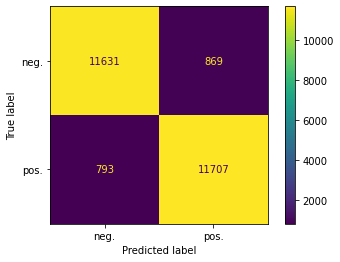

In [20]:
# Evaluate on the chosen test set.
y_pred, pred_labels, pred_probs = getPrediction(test['sentence'], classes)
y_true = test['polarity']

# Display results
clf_report = classification_report(y_true, y_pred, target_names=classes)
print(clf_report)

conf_matrix = confusion_matrix(y_true, y_pred)
print(f'Accuracy: {sum(np.diag(conf_matrix))}/{np.sum(conf_matrix)}={sum(np.diag(conf_matrix))/np.sum(conf_matrix)}')

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=classes)
disp.plot()
plt.savefig('BERT_res.svg')
plt.show()

### (Binary class predictions only)

In [ ]:
#if binary_classes:
#    estimator.evaluate(input_fn=test_input_fn, steps=None)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-02-12T21:04:20Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from gs://bert-tfhub/aclImdb_v1/model.ckpt-468
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-02-12-21:06:05
INFO:tensorflow:Saving dict for global step 468: auc = 0.86659324, eval_accuracy = 0.8664, f1_score = 0.8659711, false_negatives = 375.0, false_positives = 293.0, global_step = 468, loss = 0.51870537, precision = 0.880457, recall = 0.8519542, true_negatives = 2174.0, true_positives = 2158.0
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 468: gs://bert-tfhub/aclImdb_v1/model.ckpt-468


{'auc': 0.86659324,
 'eval_accuracy': 0.8664,
 'f1_score': 0.8659711,
 'false_negatives': 375.0,
 'false_positives': 293.0,
 'global_step': 468,
 'loss': 0.51870537,
 'precision': 0.880457,
 'recall': 0.8519542,
 'true_negatives': 2174.0,
 'true_positives': 2158.0}